<a href="https://colab.research.google.com/github/JLXIA/backtrader/blob/master/daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stockstats
!pip install keras_tuner
!pip install ta
!pip install alpaca-py
!pip install alpaca-trade-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=a3ef6f8f2a47f6a72421f8a4c0b3b351a0066a6cf4cee0722dc60a58a8689f69
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.7
    Uninstalling msgpack-1.0.7:
      Successfully uninstalled msgpack-1.0.7
  Attempting uninstall: websockets
  

In [ ]:
import yfinance as yf
from stockstats import StockDataFrame as sdf
from datetime import datetime, date, timedelta
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import ta
import keras_tuner
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2, l1_l2
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc as sk_auc
import warnings
from sklearn.metrics import precision_score
from keras.models import Sequential
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input, Dense, concatenate, BatchNormalization, Dropout
from alpaca.data.requests import StockBarsRequest
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
drive.mount('/content/drive')
dir = '/content/drive/My Drive/'

n_epoch=120
period = '60d'
interval = '1d'
start_date = '2019-01-01'
end_date = '2024-01-01'
atr_period = 5
hhv_period = 10
mult = 2.5
cap = 0
n_steps_in = 200
n_steps_out = 30
perc_th = 0.001
api_key = 'PK2WJ7R0Q4VEAB3EA57C'
secret_key = 'nBICEM1C26CM1yCf9bgf18TKOdvTwVFQg6aPmsY5'

def exponential_decay_loss(y_true, y_pred):
  mae = tf.keras.losses.mean_absolute_error(y_true, y_pred)

  # Determine number of timesteps
  num_timesteps = tf.shape(y_pred)[1]

  # Exponential decay for weights - more emphasis on recent errors
  decay_factor = 0.95  # Adjust this to control decay rate
  weights = tf.exp(decay_factor * tf.range(num_timesteps, dtype=tf.float32))

  # Apply weights to the MAE, emphasizing later timesteps
  weighted_mae = mae * weights
  return weighted_mae

def get_alpaca_data(start_date, end_date, ticker='QQQ', interval='15Min'):
  base_url = "https://paper-api.alpaca.markets"
  api = tradeapi.REST(api_key, secret_key, base_url, api_version='v2')

  start_date = '2019-01-01'
  end_date = '2024-01-12'
  barset = api.get_bars(ticker, interval, start=start_date, end=end_date).df

  barset.index = barset.index.tz_convert('America/New_York')
  market_open = pd.Timestamp('9:30', tz='America/New_York')
  market_close = pd.Timestamp('16:00', tz='America/New_York')

  filtered_data = barset[(barset.index.time >= market_open.time()) & (barset.index.time <= market_close.time())]
  return filtered_data

def calculate_ift_stochastic(df, stochlength=5, wmalength=9):
    # Calculate Stochastic and Inverse Fisher Transform
    df['stoch'] = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=stochlength).stoch()
    df['v1'] = 0.1 * (df['stoch'] - 50)
    df['v2'] = ta.trend.WMAIndicator(df['v1'], window=wmalength).wma()
    df['ift'] = 50*((np.exp(2 * df['v2']) - 1) / (np.exp(2 * df['v2']) + 1)+1)
    # print(df)
    return df

def get_buy_sell_v(df):
  df['BuyingVolume'] = df['volume'] * (df['close'] - df['low']) / (df['high'] - df['low'])
  df['SellingVolume'] = df['volume'] * (df['high'] - df['close']) / (df['high'] - df['low'])
  df['buy_perc'] = df['BuyingVolume']/(df['SellingVolume']+df['BuyingVolume'])
  # print(df)
  return df

def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

def split_sequence_by_day(sequence, dates, n_steps_in, n_steps_out):
    """Splits a sequence into X and y pairs based on dates, ensuring each pair is from the same day.

    Args:
      sequence: A NumPy array containing the data to be split.
      dates: A NumPy array of dates corresponding to the rows in 'sequence'.
      n_steps_in: Number of input timesteps.
      n_steps_out: Number of output timesteps.

    Returns:
      np.array: X data
      np.array: y data
    """

    X, y = list(), list()
    current_day = dates[0].date()

    start_idx = 0
    for i in range(1, len(dates)):
        if dates[i].date() != current_day:
            # Process the current day's data
            daily_data = sequence[start_idx:i]
            if len(daily_data) >= n_steps_in + n_steps_out:
                X, y = _process_daily_data(daily_data, n_steps_in, n_steps_out, X, y)

            # Move to the next day
            current_day = dates[i].date()
            start_idx = i

    # Process the last day's data
    daily_data = sequence[start_idx:]
    if len(daily_data) >= n_steps_in + n_steps_out:
        X, y = _process_daily_data(daily_data, n_steps_in, n_steps_out, X, y)

    return np.array(X), np.array(y)


def _process_daily_data(daily_data, n_steps_in, n_steps_out, X, y):
    """Helper function to process a single day's data."""
    for j in range(len(daily_data) - n_steps_in - n_steps_out + 1):
        end_ix = j + n_steps_in
        out_end_ix = end_ix + n_steps_out
        seq_x, seq_y = daily_data[j:end_ix], daily_data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

def rma(df, length):
    alpha = 1 / length
    sum_val = None
    rma_values = []

    for i in range(len(df)):
        if pd.isna(sum_val):
            sum_val = df['true_range'].iloc[:i+1].mean()
        else:
            sum_val = alpha * df['true_range'].iloc[i] + (1 - alpha) * sum_val
        # print(df.index[i], df['true_range'].iloc[i], sum_val)
        rma_values.append(sum_val)

    df = df.assign(rma=rma_values)
    return df['rma']

# Function to calculate ATR
def calculate_atr(df, atr_period):
    df['true_range'] = df.apply(lambda row: max(row['high'] - row['low'], abs(row['high'] - row['close_shifted']), abs(row['low'] - row['close_shifted'])), axis=1)
    df['_ATR'] = rma(df, atr_period)
    return df

# Function to calculate HHV
def calculate_hhv(df, hhv_period, mult):
    df['AdjustedHigh'] = df['high'] - mult * df['_ATR']
    df['HHV'] = df['AdjustedHigh'].rolling(window=hhv_period).max()
    return df

# Function to determine the Trailing Stoploss
def calculate_trailing_stoploss(row):
    if row['cum_sum'] < 16:
        return row['close']
    else:
        return row['HHV']

def calculate_ift_stochastic(df, stochlength=5, wmalength=9):
    # Calculate Stochastic and Inverse Fisher Transform
    df['stoch'] = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=stochlength).stoch()
    df['v1'] = 0.1 * (df['stoch'] - 50)
    df['v2'] = ta.trend.WMAIndicator(df['v1'], window=wmalength).wma()
    df['ift'] = 50*((np.exp(2 * df['v2']) - 1) / (np.exp(2 * df['v2']) + 1)+1)
    # print(df)
    return df

def get_buy_sell_v(df):
  df['BuyingVolume'] = df['volume'] * (df['close'] - df['low']) / (df['high'] - df['low'])
  df['SellingVolume'] = df['volume'] * (df['high'] - df['close']) / (df['high'] - df['low'])
  df['buy_perc'] = df['BuyingVolume']/(df['SellingVolume']+df['BuyingVolume'])
  # print(df)
  return df

def generate_signals(data):
    data['Signal'] = 0  # 0 for no signal, 1 for buy, -1 for sell
    # when we close a position, we open a new position with same direction
    # Buy signal (crossover)
    buy_condition1 = (data['cum_sum']>16) & (data['close'] > data['TS']) & (data['close'].shift(1) <= data['TS'].shift(1))
    # buy_condition2 = (data['mfi']<0.28) & (data['aroon'] <-50) & (data['boll_pct'] < 10)
    # buy_condition = buy_condition1 & buy_condition2
    data.loc[buy_condition1, 'Signal'] = 1

    # Sell signal (crossunder)
    sell_condition1 = (data['cum_sum']>16) & (data['close'] < data['TS']) & (data['close'].shift(1) >= data['TS'].shift(1))
    # sell_condition2 = (data['mfi']>0.80) & (data['aroon'] >50) & (data['boll_pct'] >90)
    # sell_condition = sell_condition1 & sell_condition2
    data.loc[sell_condition1, 'Signal'] = -1
    return data

def create_ht_lstm(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(hp.Int("units1", min_value=16, max_value=128, step=32), activation='relu',input_shape=(n_steps_in, n_features))))
  model.add(layers.RepeatVector(n_steps_out))
  # dropout = hp.Float("dropout", min_value=0.1, max_value=0.25)
  dropout=0.15
  model.add(layers.Dropout(dropout))
  model.add(layers.Bidirectional(layers.LSTM(hp.Int("units2", min_value=16, max_value=128, step=32), activation='relu',return_sequences=True)))
  model.add(layers.Dropout(dropout))
  model.add(layers.Bidirectional(layers.LSTM(hp.Int("units1", min_value=16, max_value=128, step=32), activation='relu',return_sequences=True, kernel_regularizer=l2(hp.Float("kernel_regularizer", min_value=1e-5, max_value=1e-3,  sampling="log")))))
  model.add(layers.Dropout(dropout))
  model.add(layers.TimeDistributed(layers.Dense(n_features)))
  model.compile(
        optimizer=optimizers.RMSprop(lr=hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")), loss='mse'
    )
  return model

def create_ht_lstm_classification(hp):
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(hp.Int("units1", min_value=8, max_value=128, step=32), activation='relu',return_sequences=True, input_shape=(n_steps_in, n_features))))
  # dropout = hp.Float("dropout", min_value=0.1, max_value=0.25)
  dropout=0.15
  model.add(layers.Dropout(dropout))
  model.add(layers.Bidirectional(layers.LSTM(hp.Int("units2", min_value=8, max_value=128, step=32), activation='relu',return_sequences=True)))
  model.add(layers.Dropout(dropout))
  model.add(layers.Bidirectional(layers.LSTM(hp.Int("units1", min_value=8, max_value=128, step=32), activation='relu',kernel_regularizer=l2(hp.Float("kernel_regularizer", min_value=1e-5, max_value=1e-3,  sampling="log")))))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(hp.Int("units3", min_value=8, max_value=128, step=32), activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))
  model.compile(
        optimizer=optimizers.RMSprop(lr=hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")), loss='sparse_categorical_crossentropy', metrics=['accuracy']
    )
  return model

def run_tuner():
  tuner = keras_tuner.BayesianOptimization(
      hypermodel=create_ht_lstm,
      objective="val_loss",
      # max_trials=3,
      # executions_per_trial=2,
      overwrite=True,
      directory=dir,
      project_name="ht_lstm",
  )
  model = create_ht_lstm(keras_tuner.HyperParameters())
  tuner.search(X, y, epochs=n_epoch, validation_split=0.05,callbacks=[tf.keras.callbacks.TerminateOnNaN()], shuffle=False)
  models = tuner.get_best_models(num_models=1)
  best_model = models[0]
  tuner.results_summary()

def run_tuner_v2():
  tuner = keras_tuner.BayesianOptimization(
      hypermodel=create_ht_lstm_classification,
      objective="val_accuracy",
      # max_trials=3,
      # executions_per_trial=2,
      overwrite=True,
      directory=dir,
      project_name="ht_lstm",
  )
  model = create_ht_lstm_classification(keras_tuner.HyperParameters())
  tuner.search(X, y, epochs=n_epoch, validation_split=0.05,callbacks=[tf.keras.callbacks.TerminateOnNaN()], shuffle=False)
  models = tuner.get_best_models(num_models=1)
  best_model = models[0]
  tuner.results_summary()

def get_ts(df):
  df['close_shifted'] = df['close'].shift(1)
  df = calculate_atr(df, atr_period)
  df = calculate_hhv(df, hhv_period, mult)
  df['cum_sum'] = np.cumsum(np.ones(len(df)))
  df['ts'] = df.apply(calculate_trailing_stoploss, axis=1)
  return df

def get_atr_cross(df):
  df['atr_signal'] = 0  # Default to 0

  # Crossover: 1, Crossunder: -1
  df.loc[df['close'] > df['ts'], 'atr_signal'] = 1
  df.loc[df['close'] < df['ts'], 'atr_signal'] = -1
  return df

def calculate_targets(df):
    """
    Calculates training targets based on stock price and buy/sell signals.

    Args:
        df (pd.DataFrame): DataFrame containing 'price' and 'signal' columns.

    Returns:
        pd.Series: Series of target values (1 for positive return, -1 for negative).
    """
    df['Target'] = np.nan
    for i, (date, row) in enumerate(df.iterrows()):
      price = row['close']
      signal = row['atr_signal']
      if signal > 0:
          # Find the first 'sell' after current 'buy'
          future_sells = df.iloc[i+1:]['atr_signal'] == -1
          if (future_sells == False).all():
            next_sell_index = df.index[-1]
            # print(next_sell_index)
          else:
            next_sell_index = df.index[i + 1:][future_sells].min()  # Get index of next sell

          future_sell_price = df.loc[next_sell_index, 'close']
          return_pct = (future_sell_price - price) / price
          df.at[date, 'Target'] = 1 if return_pct > 0 else 0
      # elif signal < 0:
      #     # Find the first 'buy' after current 'sell'
      #     future_buys = df.iloc[i+1:]['atr_signal'] == 1
      #     if (future_buys == False).all():
      #       next_buy_index = df.index[-1]
      #       # print(next_buy_index)
      #     else:
      #       next_buy_index = df.index[i + 1:][future_buys].min()

      #     future_buy_price = df.loc[next_buy_index, 'close']
      #     return_pct = (price - future_buy_price) / price
      #     df.at[date, 'Target'] = 1 if return_pct > 0 else 0
    # print(df['Target'].to_string())
    return df['Target']

Mounted at /content/drive


In [ ]:
run_tuner()

In [ ]:
# long term prediction
# watching=['SPY']
# watching = ['OKE', 'WELL', 'KEY', 'DE', 'EXC', 'AMT', 'LHX', 'MDT', 'INTC', 'GOOGL', 'BOOT', 'PYPL', 'REGN', 'TGT', 'MRK', 'DOW', 'ALK', 'NEE', 'PAYX', 'WAT', 'CHRW', 'EW', 'BK', 'PEP', 'NVDA', 'LLY', 'V', 'QRVO', 'UNH', 'QCOM', 'IBM', 'MSFT', 'HON', 'UPS', 'TSLA', 'VZ', 'KO', 'ED', 'ORLY', 'DIS', 'CTAS', 'MAR', 'HD', 'MET', 'HAS', 'MCD', 'AOS', 'MMM', 'SYK', 'NWL', 'LMT', 'GOOG', 'XOM', 'APH', 'FIS', 'KR', 'DLTR', 'BAC', 'ADBE', 'META', 'CVX', 'SYF', 'SLB', 'SCHW', 'T', 'PFE', 'DD', 'JNJ', 'PH', 'MU', 'JPM', 'WM', 'CLX', 'PG', 'ADP', 'BA', 'COST', 'WBA', 'DUK', 'CAT', 'WMT', 'AMZN', 'PANW', 'CDNS', 'EMN', 'EA', 'RTX', 'CRM', 'MO', 'ISRG', 'AAPL', 'CSCO', 'MA', 'CHTR', 'NSC', 'AVGO']
ticker = 'TSLA'

INDICATORS = ['close',
              # 'open', 'high', 'low',
              # 'pct_change',
              # 'volume_5_sma',
              # 'volume_10_sma', 'volume_30_sma',
              # 'close_5_sma',
              # 'close_10_sma',
              # 'close_20_sma',
              # 'close_60_sma', 'close_120_sma',
              'vwma_5',
              'vwma_10', 'vwma_20','vwma_30',
              'mfi',
              'aroon',
              # 'boll_pct',
              # 'ift',
              # 'buy_perc',
              # 'rsi',
              # 'kdjk', 'kdjd', 'kdjj',
              # 'stochrsi',
              # 'cci',
              # 'atr',
              # 'ts',
              # 'atr_signal',
              # 'wt1',
              # 'wt2',
              # 'macd',
              # 'cti','high_5_cti', 'low_5_cti',
              # 'qqe',

              # 'volume', 'vwap'

              # 'kdjk_x_kdjd','kdjk_xu_kdjd', 'kdjk_xd_kdjd'
              # 'macds_xu_macdh', 'macdh_xu_macds'
              # 'boll', 'boll_ub', 'boll_lb'
              # 'vix',
              ]



def get_data(ticker, interval='15Min', start_date=None, end_date=None, period=None, use_alpaca=True):
  if use_alpaca:
    data = get_alpaca_data(ticker=ticker, start_date=start_date, end_date=end_date, interval=interval)
  else:
    if start_date and end_date:
      data = yf.download(tickers=ticker, start=start_date, end=end_date, interval=interval, group_by='ticker', auto_adjust=True)
    else:
      data = yf.download(tickers=ticker, period=period, interval=interval, group_by='ticker', auto_adjust=True)
  # data.index.drop_duplicates(keep='first')
  data.dropna(inplace=True)
  # print(data[data.index=='2023-12-01'])
  indicators = {}
  # print(data)

  ticker_df = data
  # ticker_df = ticker_df.resample('4H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

  stock = sdf.retype(ticker_df)
  stock.index.drop_duplicates(keep='first')
  # features = ['close', 'volume']
  for indicator in INDICATORS:
    if indicator == 'boll_pct':
      stock[indicator] = (stock['close'] - stock['boll_lb']) / (
        stock['boll_ub'] - stock['boll_lb']) * 100
      # print(stock[indicator])
    if indicator == 'pct_change':
      stock[indicator] = stock['close'].pct_change()*100
    if indicator == 'change':
      stock[indicator] = stock['close'].pct_change()*stock['close']
    if indicator == 'ift':
      stock[indicator] = calculate_ift_stochastic(stock)[indicator]
    if indicator == 'buy_perc':
      stock[indicator] = get_buy_sell_v(stock)[indicator]
    if indicator == 'ts':
      stock[indicator] = get_ts(stock)[indicator]
    if indicator == 'atr_signal' and 'ts' in INDICATORS:
      stock[indicator] = get_atr_cross(stock)[indicator]
    if indicator == 'vix':
      vix = yf.download(tickers=['^VIX'], start=start_date, end=end_date, interval=interval, group_by='ticker', auto_adjust=True)
      stock[indicator] = vix['Close']

    indicators[indicator] = stock[indicator]
  # print(stock)
  return stock, indicators

In [ ]:
# lstm predict next n seq-multi-pred
# stock, indicators = get_data(ticker=ticker, interval=interval, start_date=start_date, end_date=end_date, use_alpaca=False)
stock, indicators = get_data(ticker=ticker, interval=interval, period='5y', use_alpaca=False)
dates = stock.index
# print(dates)
scaler_train = MinMaxScaler(feature_range=(0, 1))
# scaler_train = StandardScaler()

in_seqs = []

for indicator in indicators:
  in_seq = np.array(indicators[indicator][-cap:])
  in_seq = in_seq.reshape((-1, 1))
  in_seqs.append(in_seq)

# print(in_seqs)

dataset = np.hstack(in_seqs)
# print(dataset)

dataset = scaler_train.fit_transform(dataset)
X, y = split_sequence(dataset, n_steps_in, n_steps_out)
# X, y = split_sequence_by_day(dataset, dates, n_steps_in, n_steps_out)
print(X.shape, y.shape)
batch_size = X.shape[0]
n_features = X.shape[2]
# print(X)



[*********************100%%**********************]  1 of 1 completed

(1031, 200, 7) (1031, 30, 7)


In [ ]:
# lstm predict next n seq-predct close only

stock, indicators = get_data(ticker=ticker, interval=interval,start_date=start_date, end_date=end_date, use_alpaca=False)
dates = stock.index
# print(dates)
scaler_train1 = MinMaxScaler(feature_range=(0, 1))
scaler_train2 = MinMaxScaler(feature_range=(0, 1))
in_seqs = []

for indicator in indicators:
  in_seq = np.array(indicators[indicator][-cap:])
  in_seq = in_seq.reshape((-1, 1))
  in_seqs.append(in_seq)

dataset = np.hstack(in_seqs)
# print(dataset)

# X, y = split_sequence_by_day(dataset, dates, n_steps_in, n_steps_out)
X, y = split_sequence(dataset, n_steps_in, n_steps_out)
y = y[:, :, 0]
batch_size = X.shape[0]
n_features = X.shape[2]
X = scaler_train1.fit_transform(X.reshape((-1, n_features)))
X = X.reshape((-1, n_steps_in, n_features))
y = scaler_train2.fit_transform(y.reshape((-1, 1)))
y = y.reshape((-1, n_steps_out, 1))
print(X.shape, y.shape)

# print(X)

[*********************100%%**********************]  1 of 1 completed

(1029, 200, 7) (1029, 30, 1)


In [ ]:
#lstm predict next bar's return

stock, indicators = get_data(ticker, interval=interval, start_date=start_date, end_date=end_date)
dates = stock.index
# print(dates)
scaler_train1 = MinMaxScaler(feature_range=(0, 1))
# scaler_train2 = MinMaxScaler(feature_range=(0, 1))

in_seqs = []

for indicator in indicators:
  in_seq = np.array(indicators[indicator][-cap:])
  in_seq = in_seq.reshape((-1, 1))
  in_seqs.append(in_seq)

dataset = np.hstack(in_seqs)
dataset = dataset[~np.isnan(dataset).any(axis=1)]
# print(dataset)

# dataset = scaler_train.fit_transform(dataset)
X, _y = split_sequence(dataset, n_steps_in, n_steps_out)
n_price = _y[:, :, 0]
# print(n_price)
n_returns = np.zeros((n_price.shape[0], 1))

for i in range(n_returns.shape[0]):
  if (n_price[i, -1] - n_price[i, 0])/n_price[i, 0] > perc_th:
    n_returns[i, 0] = 1
  else:
    n_returns[i, 0] = 0


# print(n_returns)
y = n_returns
# print(X[0, :, 0],n_price, y)
# y = np.mean(y, axis=1)

# # y = y.reshape((-1,1))
n_features = X.shape[2]
X = scaler_train1.fit_transform(X.reshape((-1, n_features)))
X = X.reshape((-1, n_steps_in, n_features))
# y = scaler_train2.fit_transform(y.reshape((-1, 1)))
# y = y.reshape((-1, 1))

print(X.shape, y.shape)

batch_size = X.shape[0]
n_features = X.shape[2]
# print(X)
print(np.isnan(X).any(), np.isfinite(X).all())
print(np.isnan(y).any(), np.isfinite(y).all())



In [ ]:
stock, features = get_data(ticker=ticker, interval=interval, start_date=start_date, end_date=end_date, use_alpaca=True)

In [ ]:
# traidtional ml with time seq
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc as sk_auc
import warnings
from sklearn.metrics import precision_score
from keras.models import Sequential
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input, Dense, concatenate, BatchNormalization, Dropout


warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pct_th = 0.0
next_n = 10
n_steps = 16

def train_model(stock, features, n_steps, deep_learning=False, next_n=None):
  # use atr stoploss to stop buy or sell, get a dynamic return window
  print(n_steps)
  stock.dropna(inplace=True)
  # stock['Target'] = calculate_targets(stock.copy())

  stock['PctChangeNextNDays'] = (stock['close'].shift(-next_n) / stock['close'] - 1) * 100
  stock['Target'] = (stock['PctChangeNextNDays'] >pct_th).astype(int)

  # stock['PctChangePrevNDays'] = (stock['close']/stock['close'].shift(next_n) - 1) * 100

  # stock['next_n_days_avg_price'] = stock['close'].rolling(next_n).mean().shift(-next_n)
  # stock['average_return'] = (stock['next_n_days_avg_price'] / stock['close'] - 1) * 100
  # stock['Target'] = (stock['average_return'] >pct_th).astype(int)
  # stock['Target'] = pd.cut(stock['average_return'], bins=[-float('inf'), -pct_th, pct_th, float('inf')],
  #                               labels=[-1, 0, 1], ordered=False)
  # print(stock[['close', 'pct_change', 'Target']][-100:].to_string())
  stock.dropna(inplace=True)

  # print(stock)
  # Create a time sequence of features
  for col in features:
      for i in range(1, n_steps + 1):
          stock[f'{col}_lag_{i}'] = stock[col].shift(i)

  stock.dropna(inplace=True)

  # # Split the dataset into features and target variable
  X = stock[[f'{col}_lag_{i}' for col in features for i in range(1, n_steps + 1)]]
  # X = stock[features]
  # X = stock.copy()
  y = stock['Target']
  # print(X)
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11)

  # Standardize the feature values
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  if deep_learning:
    # Input Layer
    input_tensor = Input(shape=(X_train_scaled.shape[1],))

    # Dense Layer #1 (Wider)
    x = layers.Dense(64, activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)  # Dropout rate of 0.2

    # Bottleneck Layer (Narrower)
    x = layers.Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Skip Connection
    skip_output = layers.Dense(16, activation='relu')(x)
    skip_output = BatchNormalization()(skip_output)
    skip_output = Dropout(0.2)(skip_output)

    # Dense Layer #2  (Wider)
    x = layers.Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = concatenate([x, skip_output])
    # Output Layer
    output = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, validation_split=0.4)
    y_probs = model.predict(X_test_scaled)
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    # Calculate AUPR
    aupr = sk_auc(recall, precision)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Print the best threshold
    print(f"Best Threshold: {best_threshold}")

    # Print AUPR, precision, and recall
    print(f"AUPR: {aupr}")
    print("Precision-Recall Curve:")
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return model, scaler, None
  else:
    model = LogisticRegression(class_weight='balanced')
    # model = KNeighborsClassifier(n_neighbors=3)
    # model = RandomForestClassifier(class_weight='balanced')
    # # model = MLPClassifier(hidden_layer_sizes=120,  max_iter=500)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate AUC
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
    precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_probs)

    print(f"AUC: {auc}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", classification_rep)
    print('best th', best_threshold)
    return model, scaler, (auc, precision_class_0, precision_class_1)

metrics = dict()
# stock, features = get_data()
# stock, features = get_data(ticker=ticker, interval='5min', start_date=start_date, end_date=end_date)
# model, scaler, metrics = train_model(stock.copy(), features.keys(), next_n=next_n, n_steps=n_steps, deep_learning=False)
# for n_steps in range(2, 45):
#   _, scaler, m = train_model(stock.copy(), features, n_steps=n_steps)
#   metrics[n_steps] = m

for next_n in range(1, 14):
  for n_steps in range(2, 25):
    if n_steps>=next_n:
      _, scaler, m = train_model(stock.copy(), features.keys(), next_n=next_n, n_steps=n_steps)
      metrics[(n_steps, next_n)] = m


In [ ]:
# traidtional ml with time seq on diff time scale

pct_th = 0
next_n = 10
n_steps = 16

def train_model(stock, features, n_steps, deep_learning=False, next_n=None):
  # use atr stoploss to stop buy or sell, get a dynamic return window
  print(n_steps)
  stock.dropna(inplace=True)
  stock['Target'] = calculate_targets(stock.copy())

  # stock['PctChangeNextNDays'] = (stock['close'].shift(-next_n) / stock['close'] - 1) * 100
  # stock['Target'] = (stock['PctChangeNextNDays'] >pct_th).astype(int)

  # stock['PctChangePrevNDays'] = (stock['close']/stock['close'].shift(next_n) - 1) * 100

  # stock['next_n_days_avg_price'] = stock['close'].rolling(next_n).mean().shift(-next_n)
  # stock['average_return'] = (stock['next_n_days_avg_price'] / stock['close'] - 1) * 100
  # stock['Target'] = (stock['average_return'] >pct_th).astype(int)
  # stock['Target'] = pd.cut(stock['average_return'], bins=[-float('inf'), -pct_th, pct_th, float('inf')],
  #                               labels=[-1, 0, 1], ordered=False)
  # print(stock[['close', 'pct_change', 'ts', 'atr_signal', 'Target']][-100:].to_string())
  stock.dropna(inplace=True)

  # print(stock)
  # Create a time sequence of features
  for col in features:
      for i in range(1, n_steps + 1):
          stock[f'{col}_lag_{i}'] = stock[col].shift(i)

  stock.dropna(inplace=True)

  # # Split the dataset into features and target variable
  X = stock[[f'{col}_lag_{i}' for col in features for i in range(1, n_steps + 1)]]
  # X = stock.copy()
  y = stock['Target']
  # print(X)
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=11)

  # Standardize the feature values
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  if deep_learning:
    # Input Layer
    input_tensor = Input(shape=(X_train_scaled.shape[1],))

    # Dense Layer #1 (Wider)
    x = layers.Dense(64, activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)  # Dropout rate of 0.2

    # Bottleneck Layer (Narrower)
    x = layers.Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Skip Connection
    skip_output = layers.Dense(16, activation='relu')(x)
    skip_output = BatchNormalization()(skip_output)
    skip_output = Dropout(0.2)(skip_output)

    # Dense Layer #2  (Wider)
    x = layers.Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = concatenate([x, skip_output])
    # Output Layer
    output = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, validation_split=0.4)
    y_probs = model.predict(X_test_scaled)
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    # Calculate AUPR
    aupr = sk_auc(recall, precision)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Print the best threshold
    print(f"Best Threshold: {best_threshold}")

    # Print AUPR, precision, and recall
    print(f"AUPR: {aupr}")
    print("Precision-Recall Curve:")
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return model, scaler, None
  else:
    model = LogisticRegression(class_weight='balanced')
    # model = KNeighborsClassifier(n_neighbors=3)
    # model = RandomForestClassifier()
    # # model = MLPClassifier(hidden_layer_sizes=120,  max_iter=500)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate AUC
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
    precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_probs)

    print(f"AUC: {auc}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", classification_rep)
    print('best th', best_threshold)
    return model, scaler, (auc, precision_class_0, precision_class_1)

metrics = dict()
# stock, features = get_data()
all_features = {}
for inv in ['15m', '30m', '1h', '2h', '1d']:
  stock, features = get_data(interval=inv, start_date=start_date, end_date=end_date)
  all_features[inv] = features['atr']

model, scaler, metrics = train_model(stock.copy(), features, next_n=next_n, n_steps=n_steps, deep_learning=False)
# for n_steps in range(2, 45):
#   _, scaler, m = train_model(stock.copy(), features, n_steps=n_steps)
#   metrics[n_steps] = m

# for next_n in range(1, 14):
#   for n_steps in range(2, 45):
#     if n_steps>=next_n:
#       _, scaler, m = train_model(stock.copy(), features, next_n=next_n, n_steps=n_steps)
#       metrics[(n_steps, next_n)] = m


In [ ]:
from pprint import pprint
items = list(metrics.copy().items())

# 2. Sort in descending order based on values
sorted_items = sorted(items, key=lambda item: item[1][2], reverse=True)

# 3. Convert back to a dictionary (optional)
sorted_dict = dict(sorted_items)

pprint(sorted_items)

[((17, 13), (0.5550046545513417, 0.48776978417266187, 0.610803324099723)),
 ((19, 10), (0.546089164854126, 0.4803921568627451, 0.6088193456614509)),
 ((18, 13), (0.5481009876573354, 0.4639321074964639, 0.6084507042253521)),
 ((17, 12), (0.5562978528712735, 0.48462664714494874, 0.6076294277929155)),
 ((20, 9), (0.5612371674633428, 0.49577464788732395, 0.6067892503536068)),
 ((18, 11), (0.5544315111625734, 0.4654696132596685, 0.6060606060606061)),
 ((19, 13), (0.5321889987276108, 0.45365168539325845, 0.6056737588652482)),
 ((20, 12), (0.5521043219317198, 0.4835007173601148, 0.6055555555555555)),
 ((18, 12), (0.5612956576107784, 0.4963924963924964, 0.6049723756906077)),
 ((16, 13), (0.5449406022468284, 0.4942363112391931, 0.603042876901798)),
 ((20, 10), (0.5540428793287752, 0.492816091954023, 0.6019417475728155)),
 ((22, 10), (0.5378258285455523, 0.48316251830161056, 0.6008174386920981)),
 ((23, 6), (0.5429840134896315, 0.4697406340057637, 0.598893499308437)),
 ((19, 11), (0.547485109866

In [ ]:
def test_trained_model(model, features, next_n, test_set, scaler, deep_learning=False, dl_th=0.1):
  test_set.dropna(inplace=True)
  # test_set['PctChangePrevNDays'] = (test_set['close']/test_set['close'].shift(next_n) - 1) * 100
  # print(test_set[-10:])
  for col in features:
      for i in range(1, n_steps + 1):
          test_set[f'{col}_lag_{i}'] = test_set[col].shift(i)

  # test_set.dropna(inplace=True)
  # print(test_set)
  test_set.dropna(inplace=True)
  test_X = test_set[[f'{col}_lag_{i}' for col in features for i in range(1, n_steps + 1)]]
  # print(test_X[20:100])
  test_X_scaled = scaler.transform(test_X)
  # test_set['Target'] = calculate_targets(test_set.copy())
  # Make predictions on the unseen test set
  # Create a binary target variable: 1 if the percentage change > threshold, 0 otherwise
  test_set['PctChangeNextNDays'] = (test_set['close'].shift(-next_n) / test_set['close'] - 1) * 100
  test_set['Target'] = (test_set['PctChangeNextNDays'] >pct_th).astype(int)

  # test_set['next_n_days_avg_price'] = test_set['close'].rolling(next_n).mean().shift(-next_n)
  # test_set['average_return'] = (test_set['next_n_days_avg_price'] / test_set['close'] - 1) * 100

  # test_set['Target'] = (test_set['average_return'] >pct_th).astype(int)
  # print(test_set)
  if deep_learning and dl_th:
    test_set['probs'] =  model.predict(test_X_scaled)
    y_pred_unseen = (test_set['probs']>dl_th).astype(int)
  else:
    y_pred_unseen = (model.predict_proba(test_X_scaled)>dl_th)[:, 1].astype(int)

  # Create a DataFrame for detailed predictions
  detailed_predictions = pd.DataFrame({
      'Close': test_set['close'],
      # 'atr_signal': test_set['atr_signal'],
      # 'ts': test_set['ts'],
      'PctChangeNextNDays': test_set['PctChangeNextNDays'],
      'Actual': test_set['Target'].values,
      'Predicted': y_pred_unseen
  })

  # Print classification report for the unseen test set
  classification_rep_unseen = classification_report(test_set['Target'], y_pred_unseen)
  print("Classification Report for Unseen Data (Last 10 Days):\n", classification_rep_unseen)

  return detailed_predictions

test_set_unseen, features = get_data(ticker=ticker, period='65d', interval=interval, use_alpaca=False)
# test_set_unseen, features = get_data(interval=interval, start_date='2012-01-14', end_date='2014-01-03')
result_df = test_trained_model(model, features, next_n, test_set_unseen, scaler, dl_th=0.5)
print("\nDetailed Predictions for Unseen Data:")
print(result_df.to_string())

[*********************100%%**********************]  1 of 1 completed


Classification Report for Unseen Data (Last 10 Days):
               precision    recall  f1-score   support

           0       0.50      0.18      0.27        11
           1       0.73      0.92      0.81        26

    accuracy                           0.70        37
   macro avg       0.61      0.55      0.54        37
weighted avg       0.66      0.70      0.65        37


Detailed Predictions for Unseen Data:
                 Close  PctChangeNextNDays  Actual  Predicted
Date                                                         
2024-01-02  472.649994           -0.076163       0          1
2024-01-03  468.790009            1.642523       1          1
2024-01-04  467.279999            3.242166       1          1
2024-01-05  467.920013            3.318943       1          1
2024-01-08  474.600006            2.161816       1          1
2024-01-09  473.880005            2.428887       1          1
2024-01-10  476.559998            2.406833       1          0
2024-01-11  476.35000

In [ ]:
#lstm predict probability of next n(n_steps_out) bars return >0
n_steps_in = 10
n_steps_out = 2
perc_th = 0.001
dates = stock.index
# print(dates)
scaler_train1 = MinMaxScaler(feature_range=(0, 1))
scaler_train2 = MinMaxScaler(feature_range=(0, 1))

in_seqs = []
for ticker in stocks:
  in_seq = np.array(stocks[ticker][-cap:])
  in_seq = in_seq.reshape((-1, 1))
  in_seqs.append(in_seq)

for indicator in indicators:
  in_seq = np.array(indicators[indicator][-cap:])
  in_seq = in_seq.reshape((-1, 1))
  in_seqs.append(in_seq)

dataset = np.hstack(in_seqs)
dataset = dataset[~np.isnan(dataset).any(axis=1)]
# print(dataset)

# dataset = scaler_train.fit_transform(dataset)
X, _y = split_sequence(dataset, n_steps_in, n_steps_out)
n_price = _y[:, :, 0]
# print(n_price)
n_returns = np.zeros((n_price.shape[0], 1))

for i in range(n_returns.shape[0]):
  if (n_price[i, -1] - n_price[i, 0])/n_price[i, 0] > perc_th:
    n_returns[i, 0] = 1
  else:
    n_returns[i, 0] = 0


# print(n_returns)
y = n_returns
# print(X[0, :, 0],n_price, y)
# y = np.mean(y, axis=1)

# # y = y.reshape((-1,1))
n_features = X.shape[2]
X = scaler_train1.fit_transform(X.reshape((-1, n_features)))
X = X.reshape((-1, n_steps_in, n_features))
# y = scaler_train2.fit_transform(y.reshape((-1, 1)))
# y = y.reshape((-1, 1))

print(X.shape, y.shape)

batch_size = X.shape[0]
n_features = X.shape[2]
# print(X)
print(np.isnan(X).any(), np.isfinite(X).all())
print(np.isnan(y).any(), np.isfinite(y).all())



(1248, 10, 6) (1248, 1)
False True
False True


In [ ]:
nan_indices = np.where(~np.all(np.isfinite(X), axis=1))
print("Indices with NaN:", nan_indices)

# Find indices with infinity (including positive and negative)
inf_indices = np.where(np.any(np.isinf(X), axis=1))
print("Indices with infinity:", inf_indices)


Indices with NaN: (array([ 0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([2, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]))
Indices with infinity: (array([], dtype=int64), array([], dtype=int64))


In [ ]:
# next bar short term prediction
n_steps_in = 5
n_steps_out = 1


  stock = sdf.retype(ticker_df)
  stock.index.drop_duplicates(keep='first')
  stock.dropna(inplace=True)
  stocks[ticker] = stock['close']
  if i > 0:
    continue
  for indicator in INDICATORS:
    if indicator == 'boll_pct':
      stock[indicator] = (stock['close'] - stock['boll_lb']) / (
        stock['boll_ub'] - stock['boll_lb']) * 100
    if indicator == 'pct_change':
      stock[indicator] = stock['close'].pct_change()*100
    if indicator == 'vwap':
      stock[indicator] = (stock['volume'] * stock['close']).cumsum() / stock['volume'].cumsum()
    indicators[indicator] = stock[indicator][1:]
# print(indicators)

dates = stock.index
dates = dates[1:]#first day does not have pct of change
# print(dates)
scaler_train = MinMaxScaler(feature_range=(0, 1))

in_seqs = []
for ticker in stocks:
  in_seq = np.array(stocks[ticker][-cap:])[1:]
  in_seq = in_seq.reshape((-1, 1))
  in_seqs.append(in_seq)

for indicator in indicators:
  in_seq = np.array(indicators[indicator][-cap:])
  in_seq = in_seq.reshape((-1, 1))
  in_seqs.append(in_seq)

dataset = np.hstack(in_seqs)
# print(dataset)

dataset = scaler_train.fit_transform(dataset)
X, y = split_sequence(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
batch_size = X.shape[0]
n_features = X.shape[2]
# print(X)



In [ ]:
run_tuner_v2()

Trial 10 Complete [00h 06m 52s]
val_accuracy: 0.4126984179019928

Best val_accuracy So Far: 0.6190476417541504
Total elapsed time: 01h 13m 39s


Results summary
Results in /content/drive/My Drive/ht_lstm
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
units1: 40
units2: 104
kernel_regularizer: 0.00021945906489750358
units3: 104
lr: 4.510716120658861e-05
Score: 0.6190476417541504

Trial 03 summary
Hyperparameters:
units1: 72
units2: 40
kernel_regularizer: 9.492173278081143e-05
units3: 40
lr: 0.0007121131606223716
Score: 0.5714285969734192

Trial 08 summary
Hyperparameters:
units1: 72
units2: 40
kernel_regularizer: 1.8825333795796867e-05
units3: 40
lr: 0.0005306279417939182
Score: 0.5079365372657776

Trial 00 summary
Hyperparameters:
units1: 40
units2: 72
kernel_regularizer: 1.6591955924639044e-05
units3: 40
lr: 0.00020708963595906214
Score: 0.460317462682724

Trial 01 summary
Hyperparameters:
units1: 8
units2: 72
kernel_regularizer: 0.000301151130764568
units3: 72
lr: 2.643166100751097e-05
Score: 0.4126984179019928

Trial 04 summary
Hyperparameters:
units1: 104
units2: 40

In [ ]:

learning_rate = 6.8721e-03
kernel_regularization = l2(2.7114e-05 )
unit1 = 40
unit2 = 80
n_epoch = 600
dropout = 0.15
# n_steps_in = 120
# n_steps_out = 30
decay = 0.08


# X, y = split_sequence(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
n_features = X.shape[2]
batch_size = X.shape[0]

# define model
model = keras.Sequential()
model.add(
      layers.LSTM(
          unit1,
          activation='relu',
          # stateful=True,
          input_shape=(n_steps_in, n_features),
      )
  )
model.add(layers.RepeatVector(n_steps_out))
model.add(layers.Dropout(dropout))
model.add(
    layers.LSTM(
        unit2,
        activation='relu',
        # stateful=True,
        return_sequences=True,
        kernel_regularizer=kernel_regularization,
    )
)
model.add(layers.Dropout(dropout))
model.add(
    layers.LSTM(
        unit1,
        activation='relu',
        # stateful=True,
        return_sequences=True,
        kernel_regularizer=kernel_regularization,
    )
)
model.add(layers.Dropout(dropout))
model.add(layers.TimeDistributed(layers.Dense(n_features)))

model.compile(
    optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse'
)
history = model.fit(
      X,
      y,
      epochs=n_epoch,
      batch_size=batch_size,
      validation_split=0.1,
      # callbacks=callbacks,
      shuffle=False,
  )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
model.save(dir+'new_model')

(724, 15, 12) (724, 1)
Epoch 1/300
1/1 [==============================] - 14s 14s/step - loss: 1.1077 - accuracy: 0.4731 - val_loss: 1.0906 - val_accuracy: 0.3973
Epoch 2/300
1/1 [==============================] - 0s 275ms/step - loss: 1.0911 - accuracy: 0.4839 - val_loss: 1.0755 - val_accuracy: 0.3425
Epoch 3/300
1/1 [==============================] - 0s 407ms/step - loss: 1.0751 - accuracy: 0.5576 - val_loss: 1.0591 - val_accuracy: 0.4110
Epoch 4/300
1/1 [==============================] - 0s 302ms/step - loss: 1.0601 - accuracy: 0.5192 - val_loss: 1.0393 - val_accuracy: 0.4384
Epoch 5/300
1/1 [==============================] - 0s 314ms/step - loss: 1.0403 - accuracy: 0.5253 - val_loss: 1.0146 - val_accuracy: 0.4384
Epoch 6/300
1/1 [==============================] - 0s 338ms/step - loss: 1.0142 - accuracy: 0.5054 - val_loss: 0.9819 - val_accuracy: 0.4384
Epoch 7/300
1/1 [==============================] - 0s 173ms/step - loss: 0.9834 - accuracy: 0.5131 - val_loss: 0.9402 - val_accuracy

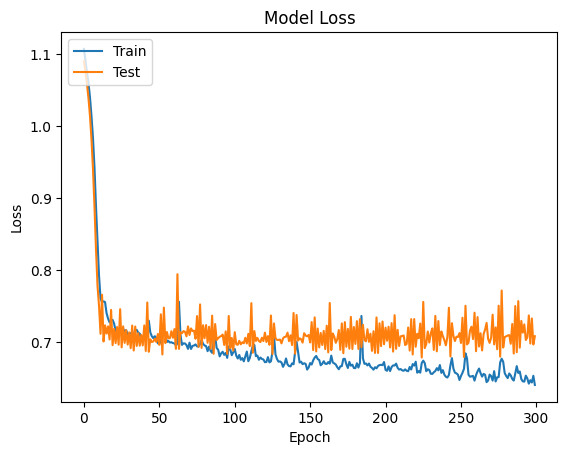

In [ ]:
#bidirectional classification

learning_rate = 0.000010927
kernel_regularization = l2(0.00012414)
unit1 = 8
unit2 = 40
unit3 = 72
n_epoch = 300
dropout = 0.15
# n_steps_in = 120
# n_steps_out = 30
decay = 0.08


# X, y = split_sequence(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
n_features = X.shape[2]
batch_size = X.shape[0]

# define model
model = keras.Sequential()
model.add(
      layers.Bidirectional(layers.LSTM(
          unit1,
          activation='relu',
          return_sequences=True,
          # stateful=True,
          input_shape=(n_steps_in, n_features),
      ))
  )
model.add(layers.Dropout(dropout))
model.add(
    layers.Bidirectional(layers.LSTM(
        unit2,
        activation='relu',
        # stateful=True,
        return_sequences=True,
        # kernel_regularizer=kernel_regularization,
    ))
)
model.add(layers.Dropout(dropout))
model.add(
    layers.Bidirectional(layers.LSTM(
        unit1,
        activation='relu',
        # stateful=True,
        # return_sequences=True,
        kernel_regularizer=kernel_regularization,
    ))
)
model.add(layers.Dropout(dropout))
model.add(layers.Dense(unit3, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(
      optimizer=optimizers.RMSprop(lr=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy']
  )

history = model.fit(
      X,
      y,
      epochs=n_epoch,
      batch_size=batch_size,
      validation_split=0.1,
      # callbacks=callbacks,
      shuffle=False,
  )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
model.save(dir+'new_model')
model_weights = model.get_weights()

Epoch 1/500
1/1 [==============================] - 13s 13s/step - loss: 0.3337 - MAE: 0.5154 - val_loss: 0.2966 - val_MAE: 0.5140
Epoch 2/500
1/1 [==============================] - 2s 2s/step - loss: 0.3015 - MAE: 0.4853 - val_loss: 0.2618 - val_MAE: 0.4788
Epoch 3/500
1/1 [==============================] - 2s 2s/step - loss: 0.2690 - MAE: 0.4527 - val_loss: 0.2185 - val_MAE: 0.4314
Epoch 4/500
1/1 [==============================] - 2s 2s/step - loss: 0.2283 - MAE: 0.4091 - val_loss: 0.1666 - val_MAE: 0.3674
Epoch 5/500
1/1 [==============================] - 2s 2s/step - loss: 0.1788 - MAE: 0.3502 - val_loss: 0.1112 - val_MAE: 0.2814
Epoch 6/500
1/1 [==============================] - 1s 1s/step - loss: 0.1292 - MAE: 0.2845 - val_loss: 0.0728 - val_MAE: 0.2131
Epoch 7/500
1/1 [==============================] - 2s 2s/step - loss: 0.1022 - MAE: 0.2475 - val_loss: 0.0722 - val_MAE: 0.2228
Epoch 8/500
1/1 [==============================] - 2s 2s/step - loss: 0.0894 - MAE: 0.2291 - val_loss:

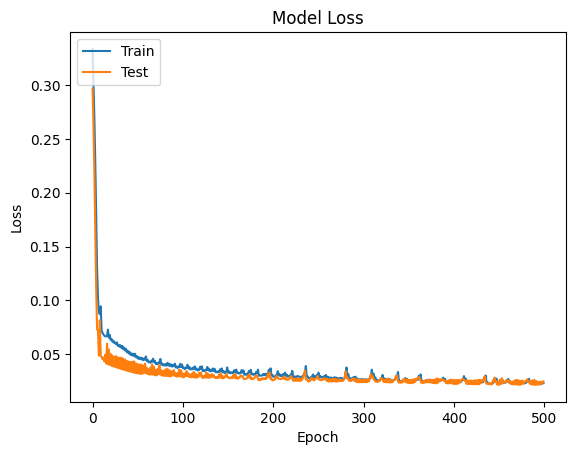

NameError: name 'train_scaler' is not defined

In [ ]:
#bidirectional
import joblib

learning_rate = 0.00044956
kernel_regularization = l2(2.354738695108064e-05)
unit1 = 48
unit2 = 16
n_epoch = 500
dropout = 0.15
# n_steps_in = 120
# n_steps_out = 30
decay = 0.08
output_size = n_features

# define model
model = keras.Sequential()
model.add(
      layers.Bidirectional(layers.LSTM(
          unit1,
          activation='relu',
          # stateful=True,
          input_shape=(n_steps_in, n_features),
      ))
  )
model.add(layers.RepeatVector(n_steps_out))
model.add(layers.Dropout(dropout))
model.add(
    layers.Bidirectional(layers.LSTM(
        unit2,
        activation='relu',
        # stateful=True,
        return_sequences=True,
        kernel_regularizer=kernel_regularization,
    ))
)
model.add(layers.Dropout(dropout))
model.add(
    layers.Bidirectional(layers.LSTM(
        unit1,
        activation='relu',
        # stateful=True,
        return_sequences=True,
        kernel_regularizer=kernel_regularization,
    ))
)
model.add(layers.Dropout(dropout))
model.add(layers.TimeDistributed(layers.Dense(output_size)))

model.compile(
    optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse', metrics=['MAE']
)

history = model.fit(
      X,
      y,
      epochs=n_epoch,
      batch_size=batch_size,
      validation_split=0.1,
      # callbacks=callbacks,
      shuffle=False,
  )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
model.save(dir+ticker+'_new_model')
with open(dir+'scaler', 'w') as f:
  joblib.dump(train_scaler, f)
# model_weights = model.get_weights()

Epoch 1/250
1/1 [==============================] - 20s 20s/step - loss: 0.0245 - MAE: 0.1026 - val_loss: 0.0595 - val_MAE: 0.2112
Epoch 2/250
1/1 [==============================] - 2s 2s/step - loss: 0.0576 - MAE: 0.1929 - val_loss: 0.0300 - val_MAE: 0.1239
Epoch 3/250
1/1 [==============================] - 2s 2s/step - loss: 0.0344 - MAE: 0.1303 - val_loss: 0.0238 - val_MAE: 0.0956
Epoch 4/250
1/1 [==============================] - 1s 1s/step - loss: 0.0235 - MAE: 0.0975 - val_loss: 0.0216 - val_MAE: 0.0848
Epoch 5/250
1/1 [==============================] - 2s 2s/step - loss: 0.0218 - MAE: 0.0912 - val_loss: 0.0229 - val_MAE: 0.0889
Epoch 6/250
1/1 [==============================] - 2s 2s/step - loss: 0.0217 - MAE: 0.0903 - val_loss: 0.0213 - val_MAE: 0.0837
Epoch 7/250
1/1 [==============================] - 2s 2s/step - loss: 0.0217 - MAE: 0.0909 - val_loss: 0.0237 - val_MAE: 0.0909
Epoch 8/250
1/1 [==============================] - 1s 1s/step - loss: 0.0218 - MAE: 0.0900 - val_loss:

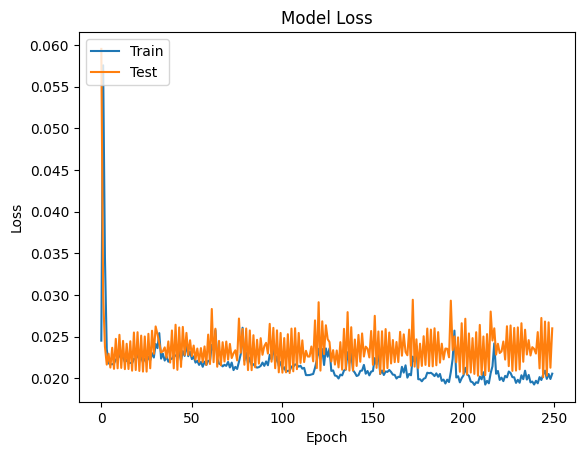

In [ ]:
#bidirectional continue train
# model = tf.keras.models.load_model(dir+'new_model')
# learning_rate = 0.0004094
kernel_regularization = l2(2.354738695108064e-05)
unit1 = 48
unit2 = 16
n_epoch = 250
dropout = 0.15
n_steps_in = 200
n_steps_out = 30
decay = 0.08
learning_rate /=10

model.compile(
    optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse', metrics=['MAE']
)
history = model.fit(
      X,
      y,
      epochs=n_epoch,
      batch_size=batch_size,
      validation_split=0.1,
      # callbacks=callbacks,
      shuffle=False,
  )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
model.save(dir+ticker+'_new_model')


Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.0154 - MAE: 0.0732 - val_loss: 0.0738 - val_MAE: 0.2334
Epoch 2/200
1/1 [==============================] - 1s 632ms/step - loss: 0.0418 - MAE: 0.1540 - val_loss: 0.0158 - val_MAE: 0.0663
Epoch 3/200
1/1 [==============================] - 1s 696ms/step - loss: 0.0326 - MAE: 0.1284 - val_loss: 0.0365 - val_MAE: 0.1434
Epoch 4/200
1/1 [==============================] - 1s 655ms/step - loss: 0.0287 - MAE: 0.1143 - val_loss: 0.0152 - val_MAE: 0.0792
Epoch 5/200
1/1 [==============================] - 1s 671ms/step - loss: 0.0182 - MAE: 0.0839 - val_loss: 0.0164 - val_MAE: 0.0935
Epoch 6/200
1/1 [==============================] - 1s 601ms/step - loss: 0.0154 - MAE: 0.0753 - val_loss: 0.0153 - val_MAE: 0.0786
Epoch 7/200
1/1 [==============================] - 1s 620ms/step - loss: 0.0152 - MAE: 0.0734 - val_loss: 0.0184 - val_MAE: 0.1037
Epoch 8/200
1/1 [==============================] - 1s 633ms/step - loss: 0.0154 - MA

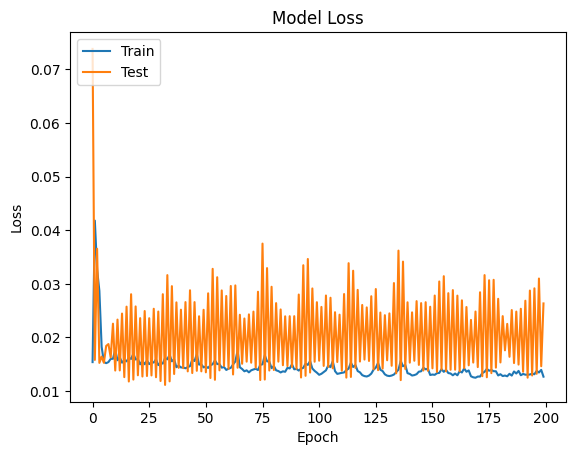

In [ ]:
# finetune

model = tf.keras.models.load_model(dir+'new_model')
# learning_rate = 0.0004094
kernel_regularization = l2(2.354738695108064e-05)
unit1 = 48
unit2 = 16
n_epoch = 200
dropout = 0.15
n_steps_in = 200
n_steps_out = 30
decay = 0.08
learning_rate /=10

for layer in model.layers:  # Exclude the last output layer
    layer.trainable = True
model.compile(
    optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse', metrics=['MAE']
)
history = model.fit(
      X,
      y,
      epochs=n_epoch,
      batch_size=batch_size,
      validation_split=0.1,
      # callbacks=callbacks,
      shuffle=False,
  )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
model.save(dir+'new_model_ft')


In [ ]:
stock, indicators = get_data(ticker=ticker, interval=interval, period='2y', use_alpaca=False)
dates = stock.index
# print(dates)
scaler_train2 = MinMaxScaler(feature_range=(0, 1))

in_seqs = []

for indicator in indicators:
  in_seq = np.array(indicators[indicator][-cap:])
  in_seq = in_seq.reshape((-1, 1))
  in_seqs.append(in_seq)

dataset = np.hstack(in_seqs)
# print(dataset)

dataset = scaler_train2.fit_transform(dataset)
X, y = split_sequence(dataset, n_steps_in, n_steps_out)
# X, y = split_sequence_by_day(dataset, dates, n_steps_in, n_steps_out)
print(X.shape, y.shape)
batch_size = X.shape[0]
n_features = X.shape[2]

[*********************100%%**********************]  1 of 1 completed

(275, 200, 7) (275, 30, 7)


In [ ]:
model = tf.keras.models.load_model(dir+'new_model')

In [ ]:
model.save(dir+'best_qqq')

Index(['2023-09-07', '2023-09-08', '2023-09-11', '2023-09-12', '2023-09-13',
       '2023-09-14', '2023-09-15', '2023-09-18', '2023-09-19', '2023-09-20',
       '2023-09-21', '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-27',
       '2023-09-28', '2023-09-29', '2023-10-02', '2023-10-03', '2023-10-04',
       '2023-10-05', '2023-10-06', '2023-10-09'],
      dtype='object', name='Date')
[170.60274 176.37537 180.13068 182.6165  184.23338 185.30212 186.48773
 187.9291  189.47919 190.97691 192.56125 194.2383  195.97035 197.74005
 199.5528  201.35869 202.96332 204.36641 205.57774 206.60672 207.39949
 207.91878 208.11809 207.92274 207.21884 205.84003 203.71443 200.48364
 195.65028 188.44432]


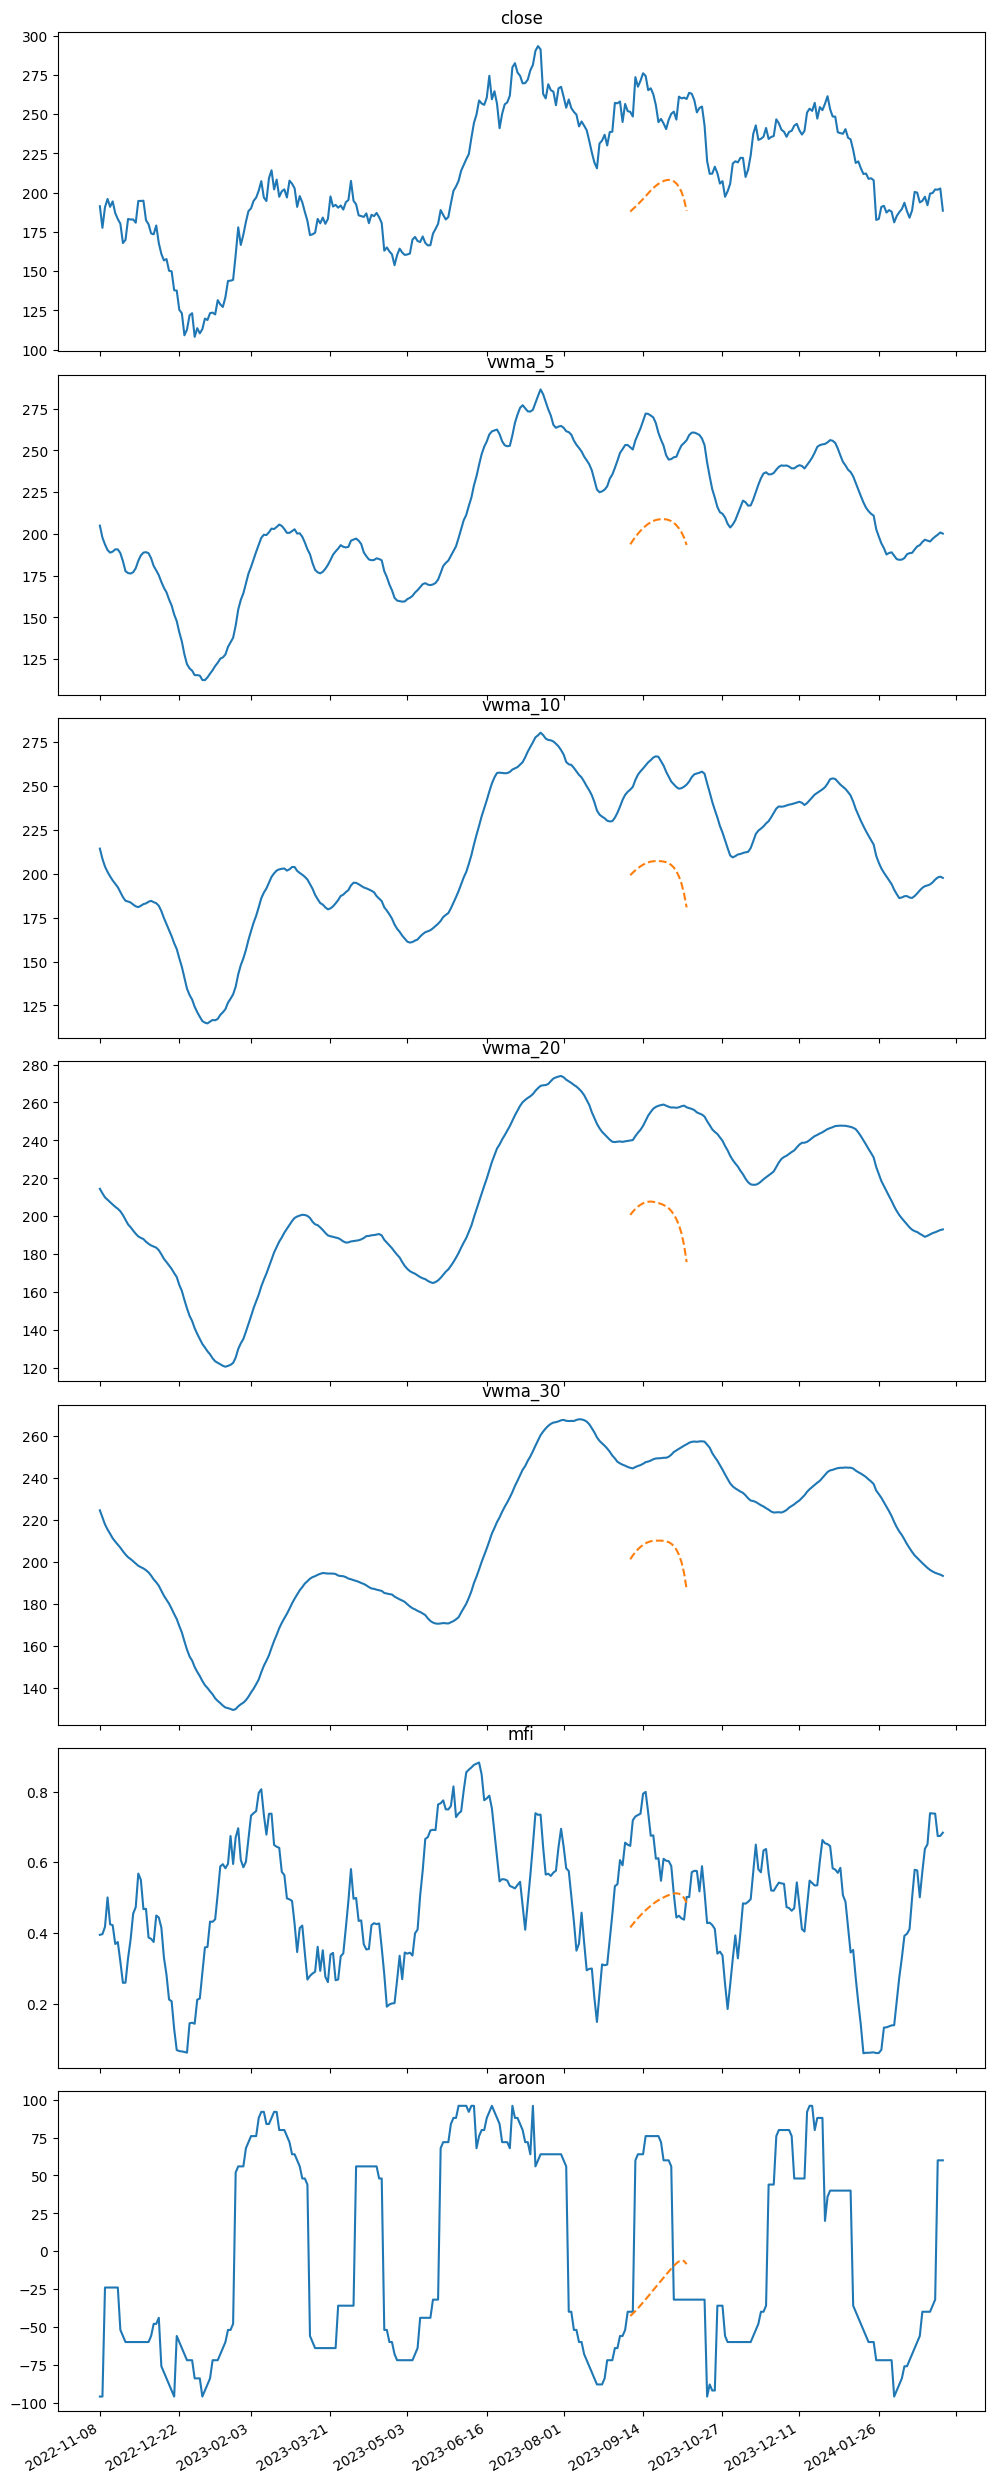

In [ ]:
# plot for full model stateless-n features
import matplotlib.dates as mdates

test_cut = n_steps_out+100
test_seq = []
shift = 7

for indicator in INDICATORS:
  test_seq.append(indicators[indicator][-n_steps_in-test_cut:])

transformed = np.array(test_seq).transpose()
transformed = scaler_train.transform(transformed)
x_input = transformed[:n_steps_in, :]
# print(transformed.shape)
y_output = transformed[n_steps_in:, :]
x_input = x_input.reshape((1, n_steps_in, -1))
# print(x_input.shape)
yhat = model.predict(x_input, verbose=0)
# print(yhat.shape)
yhat = yhat.reshape((n_steps_out, -1))
yhat = scaler_train.inverse_transform(yhat)
yhat = yhat.transpose()
# print(yhat)

x = dates.astype(str)[-n_steps_in-test_cut:]
print(x[-test_cut:-test_cut+n_steps_out][shift:])
display = INDICATORS
fig, ax = plt.subplots(len(display), 1, figsize=(10, 30), sharex = True)
fig.tight_layout()
print(yhat[0])
for i in range(len(display)):
  ax[i].set_title(display[i], loc='center')
  ax[i].plot(x, test_seq[i])
  ax[i].plot(x[-test_cut:-test_cut+n_steps_out][shift:], yhat[i][shift:], linestyle='--')

ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.show()

(210, 7)
(1, 200, 7)


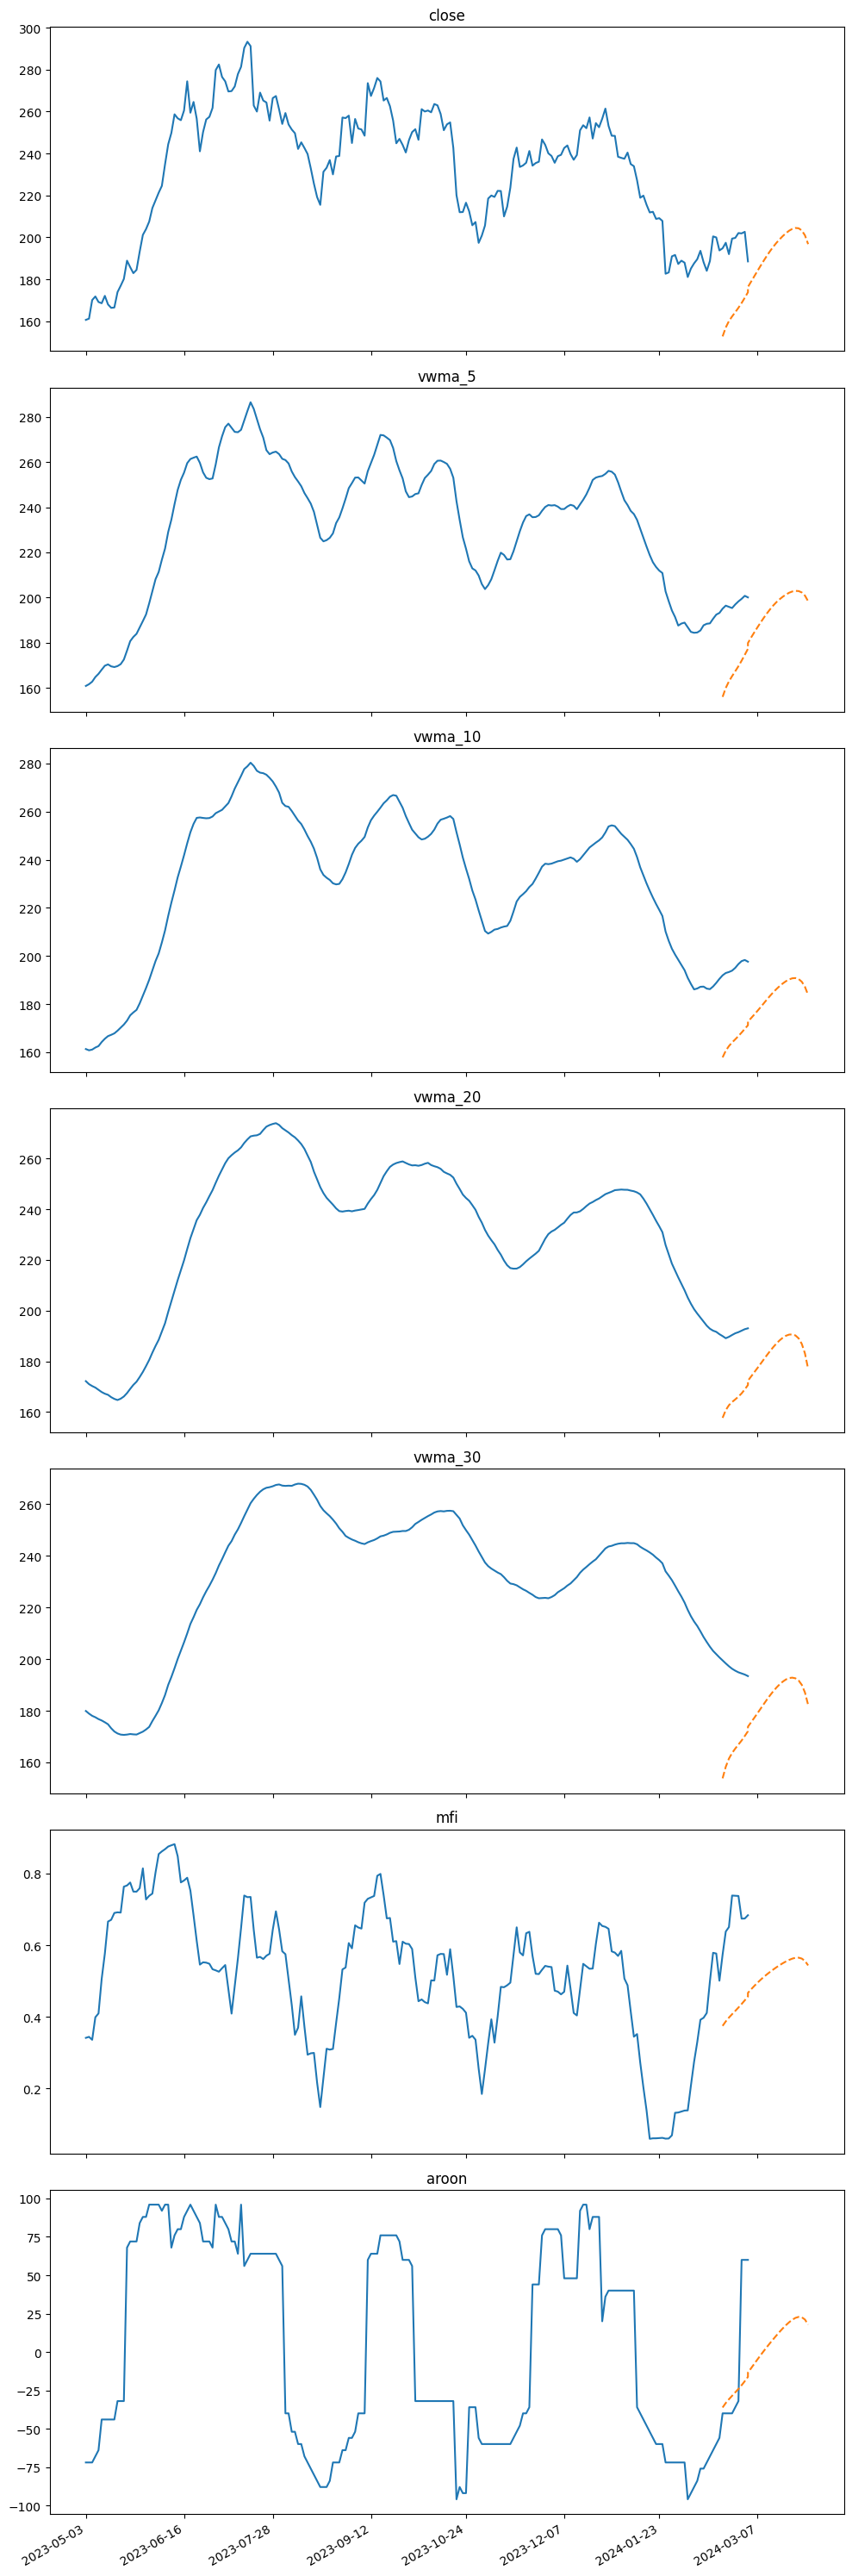

In [ ]:
# predict best QQQ model
# plot loop for future stateless
import matplotlib.dates as mdates
import datetime as dt

overlap = 10
test_seq = []
shift = 1
begin = dt.datetime.today()
# begin = dt.datetime(2024, 1, 5)
then = begin + dt.timedelta(days=n_steps_out)
days = mdates.drange(begin,then,dt.timedelta(days=1))
dts = mdates.num2date(days)

future = [x.strftime('%Y-%m-%d') for x in dts]
# _, indicators = get_data(ticker=ticker, interval=interval, period='2y', use_alpaca=False)

for indicator in INDICATORS:
  test_seq.append(indicators[indicator][-n_steps_in-overlap:])
transformed = np.array(test_seq).transpose()
transformed = scaler_train.transform(transformed)
x_input = transformed[:n_steps_in, :]
print(transformed.shape)
y_output = transformed[n_steps_in:, :]
x_input = x_input.reshape((1, n_steps_in, -1))
print(x_input.shape)
yhat = model.predict(x_input, verbose=0)

yhat = yhat.reshape((n_steps_out, -1))
yhat = scaler_train.inverse_transform(yhat)
yhat = yhat.transpose()

x = dates[-n_steps_in-overlap:].format()+ future[:n_steps_out-overlap]
display = INDICATORS
fig, ax = plt.subplots(len(display), 1, figsize=(10, 30), sharex = True)
fig.tight_layout()

for i in range(len(display)):
  ax[i].set_title(display[i], loc='center')
  ax[i].plot(x[:n_steps_in+overlap],test_seq[i])
  ax[i].plot(x[-n_steps_out:][shift:], yhat[i][shift:], linestyle='--')

ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
# just close prediction plot
import matplotlib.dates as mdates

test_cut = n_steps_out+35
test_seq = []
shift = 1

for indicator in INDICATORS:
  test_seq.append(indicators[indicator][-n_steps_in-test_cut:])

transformed = np.array(test_seq).transpose()
transformed = scaler_train1.transform(transformed)
x_input = transformed[:n_steps_in, :]
print(transformed.shape)
y_output = transformed[n_steps_in:, :]
x_input = x_input.reshape((1, n_steps_in, -1))
print(x_input.shape)
yhat = model.predict(x_input, verbose=0)
# print(yhat)
yhat = yhat.reshape((n_steps_out, -1))
yhat = scaler_train2.inverse_transform(yhat)
yhat = yhat.transpose()
# print(yhat)

x = dates.astype(str)[-n_steps_in-test_cut:]
print(x)
display = INDICATORS
fig, ax = plt.subplots(len(display), 1, figsize=(10, 30), sharex = True)
fig.tight_layout()

for i in range(len(display)):
  ax[i].set_title(display[i], loc='center')
  ax[i].plot(x, test_seq[i])
  if i == 0:
    ax[i].plot(x[-test_cut:-test_cut+n_steps_out][shift:], yhat[i][shift:], linestyle='--')

# ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.gcf().autofmt_xdate()
plt.show()

NameError: name 'scaler_train1' is not defined

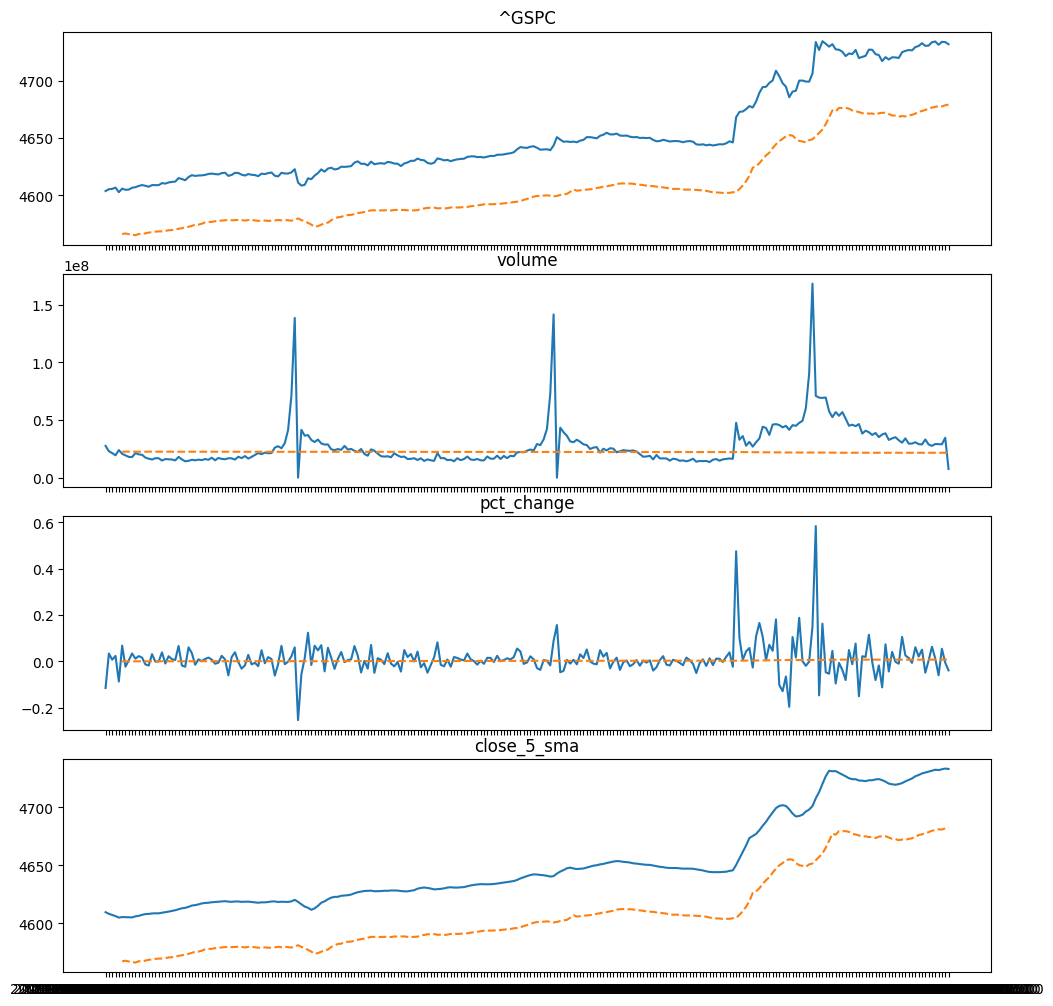

In [ ]:
# plot for next bar
import matplotlib.dates as mdates

yhats = []
moving = 250
for m in range(0, moving, 1):
  test_seq = []
  test_cut = n_steps_out+m
  for ticker in watching:
    test_seq.append(stocks[ticker][-n_steps_in-test_cut:])

  for indicator in INDICATORS:
    test_seq.append(indicators[indicator][-n_steps_in-test_cut:])

  transformed = np.array(test_seq).transpose()
  transformed = scaler_train.transform(transformed)
  x_input = transformed[:n_steps_in, :]
  # print(x_input.shape)
  x_input = x_input.reshape((1, n_steps_in, -1))

  yhat = model.predict(x_input, verbose=0)
  # print(yhat)
  yhat = yhat.reshape((n_steps_out, -1))
  yhat = scaler_train.inverse_transform(yhat)
  yhats.append(yhat.reshape(-1,))

  # print(yhat)
yhats = np.array(yhats)
yhats = yhats.transpose()
# print(yhats.shape)
raw_seq = []

x = [str(t) for t in dates[-n_steps_in-test_cut:]]
display = watching + INDICATORS
fig, ax = plt.subplots(len(display), 1, figsize=(10, 10), sharex = True)
fig.tight_layout()

for i in range(len(display)):
  ax[i].set_title(display[i], loc='center')
  ax[i].plot(x, test_seq[i])
  ax[i].plot(x[-len(yhats[i]):], yhats[i][::-1], linestyle='--')

# ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.gcf().autofmt_xdate()
plt.show()

(203, 7)
(1, 200, 7)


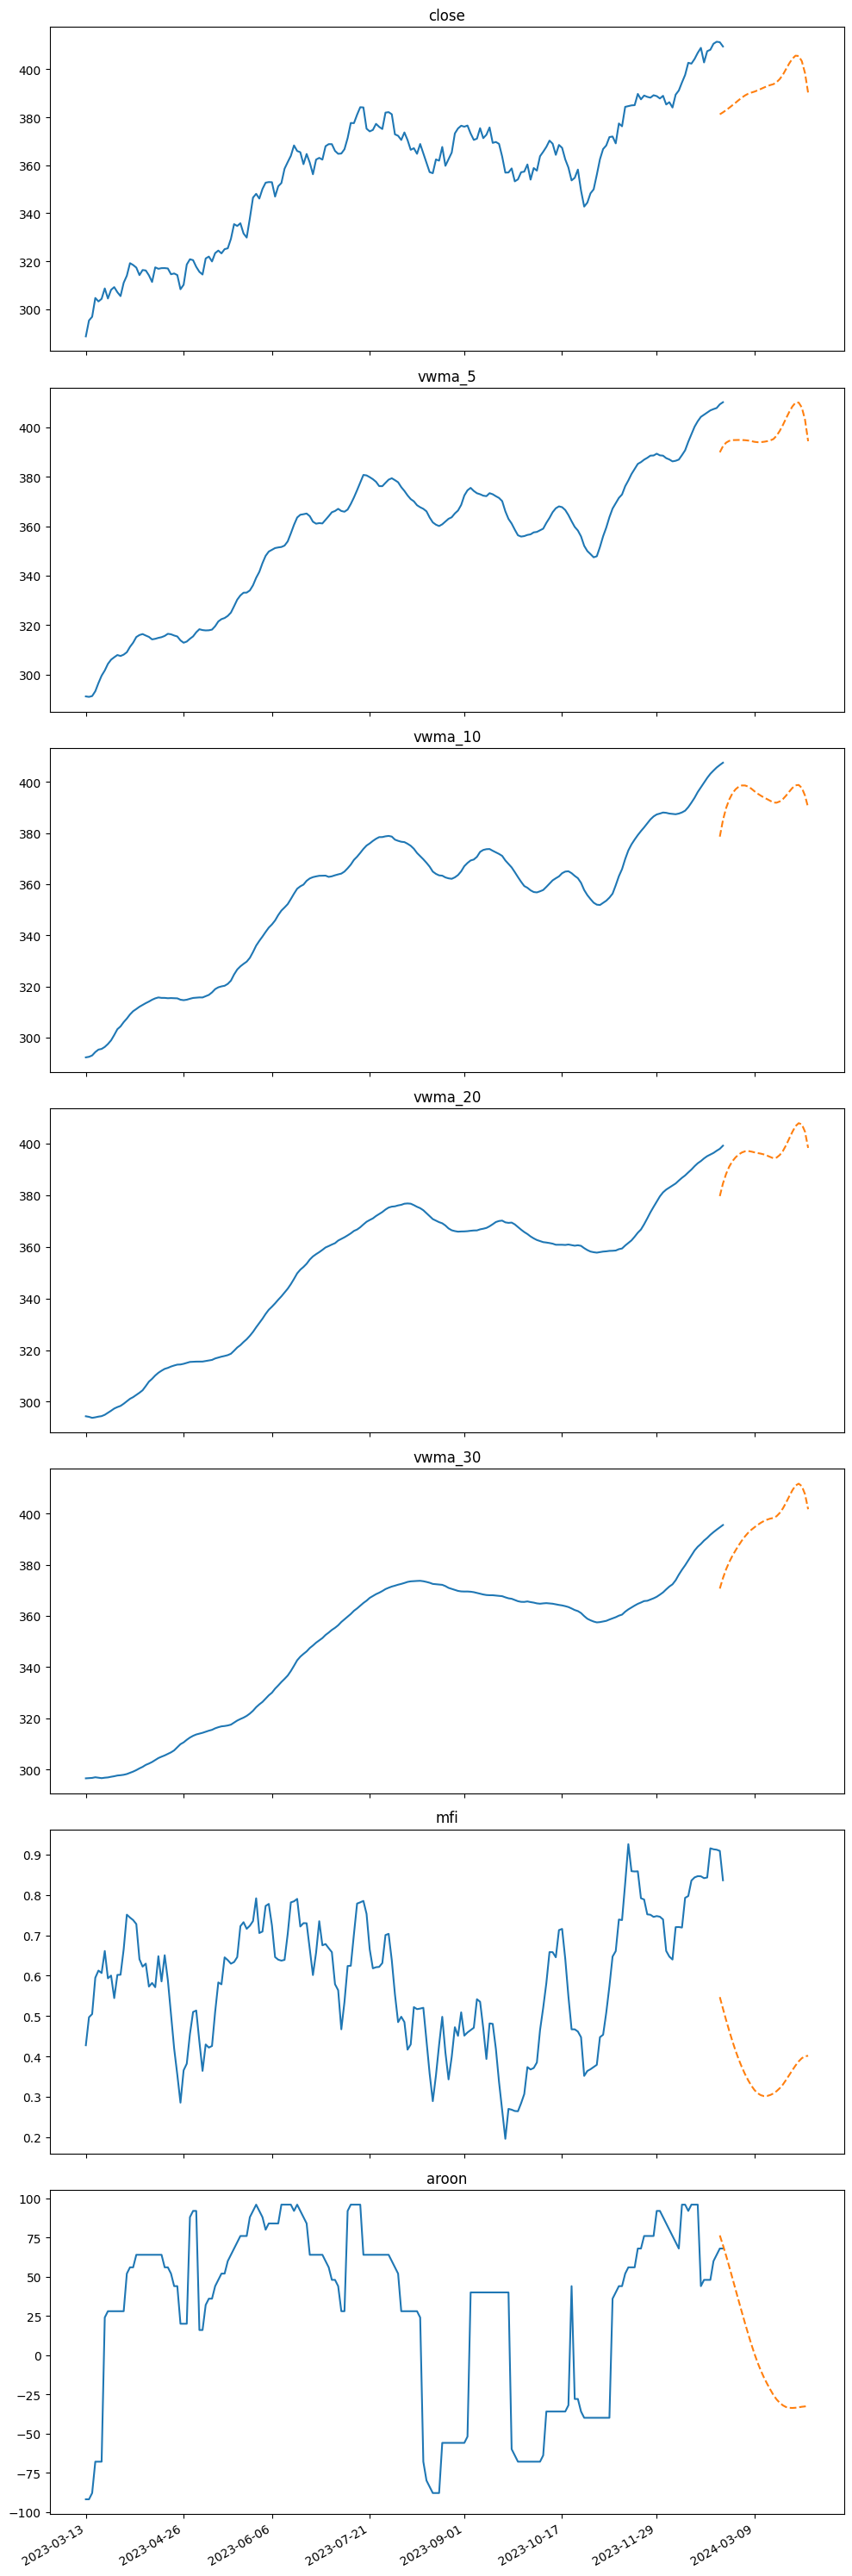

In [ ]:
# plot loop for future stateless
import matplotlib.dates as mdates
import datetime as dt

overlap = 3
test_seq = []
shift = 1
begin = dt.datetime.today()
# begin = dt.datetime(2024, 1, 5)
then = begin + dt.timedelta(days=n_steps_out)
days = mdates.drange(begin,then,dt.timedelta(days=1))
dts = mdates.num2date(days)

future = [x.strftime('%Y-%m-%d') for x in dts]

for indicator in INDICATORS:
  test_seq.append(indicators[indicator][-n_steps_in-overlap:])
transformed = np.array(test_seq).transpose()
transformed = scaler_train.transform(transformed)
x_input = transformed[:n_steps_in, :]
print(transformed.shape)
y_output = transformed[n_steps_in:, :]
x_input = x_input.reshape((1, n_steps_in, -1))
print(x_input.shape)
yhat = model.predict(x_input, verbose=0)

yhat = yhat.reshape((n_steps_out, -1))
yhat = scaler_train.inverse_transform(yhat)
yhat = yhat.transpose()

x = dates[-n_steps_in-overlap:].format()+ future[:n_steps_out-overlap]
display = INDICATORS
fig, ax = plt.subplots(len(display), 1, figsize=(10, 30), sharex = True)
fig.tight_layout()

for i in range(len(display)):
  ax[i].set_title(display[i], loc='center')
  ax[i].plot(x[:n_steps_in+overlap],test_seq[i])
  ax[i].plot(x[-n_steps_out:][shift:], yhat[i][shift:], linestyle='--')

ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
atr_period = 5
hhv_period = 10
mult = 2.5
period = '1y'
interval = '1d'
# watching = ['TSLA', 'DKS', 'PANW', 'SPY', 'QQQ']
# start = '2023-12-19'
# end = '2024-01-19'
# watching = ['DKS', 'SPY', 'QQQ', 'SOXL', 'BA', 'ASML', 'AMD', 'CCL', 'COST', 'CPE', 'DDOG', 'PYPL', 'DAL', 'TGT', 'ETSY', 'FNGU', 'HD', 'INTU', 'LOW', 'LULU', 'LYFT', 'NFLX', 'SHOP', 'TSM', 'NVDA', 'LLY', 'V', 'UBER', 'UNH', 'QCOM', 'VEEV', 'MSFT', 'X', 'UPS', 'TSLA', 'DIS', 'CTAS', 'MET', 'HAS', 'MCD', 'AOS', 'MMM', 'SYK', 'NWL', 'LMT', 'GOOG', 'XOM', 'APH', 'FIS', 'KR', 'DLTR', 'BAC', 'ADBE', 'META', 'CVX', 'SYF', 'SLB', 'SCHW', 'T', 'PFE', 'DD', 'JNJ', 'PH', 'MU', 'JPM', 'WM', 'CLX', 'PG', 'ADP', 'BA', 'COST', 'WBA', 'DUK', 'CAT', 'WMT', 'AMZN', 'PANW', 'CDNS', 'EMN', 'EA', 'RTX', 'CRM', 'MO', 'ISRG', 'AAPL', 'CSCO', 'MA', 'CHTR', 'NSC', 'AVGO']

watching = ['QQQ']
INDICATORS = [
              # 'volume',
              # 'daily_return',
              # 'vwma_5', 'vwma_10', 'vwma_20','vwma_30',
              'mfi', 'aroon',
              'boll_pct',
              'ift',
              'buy_perc'
              # 'kdjk', 'kdjd', 'kdjj'
              ]


data = yf.download(tickers=watching, period=period, interval=interval, group_by='ticker', auto_adjust=True)
# data = yf.download(tickers=watching, start=start, end=end, interval=interval, group_by='ticker', auto_adjust=True)
# print(data)
data.index.drop_duplicates(keep='first')
data.dropna(inplace=True)



[*********************100%%**********************]  1 of 1 completed


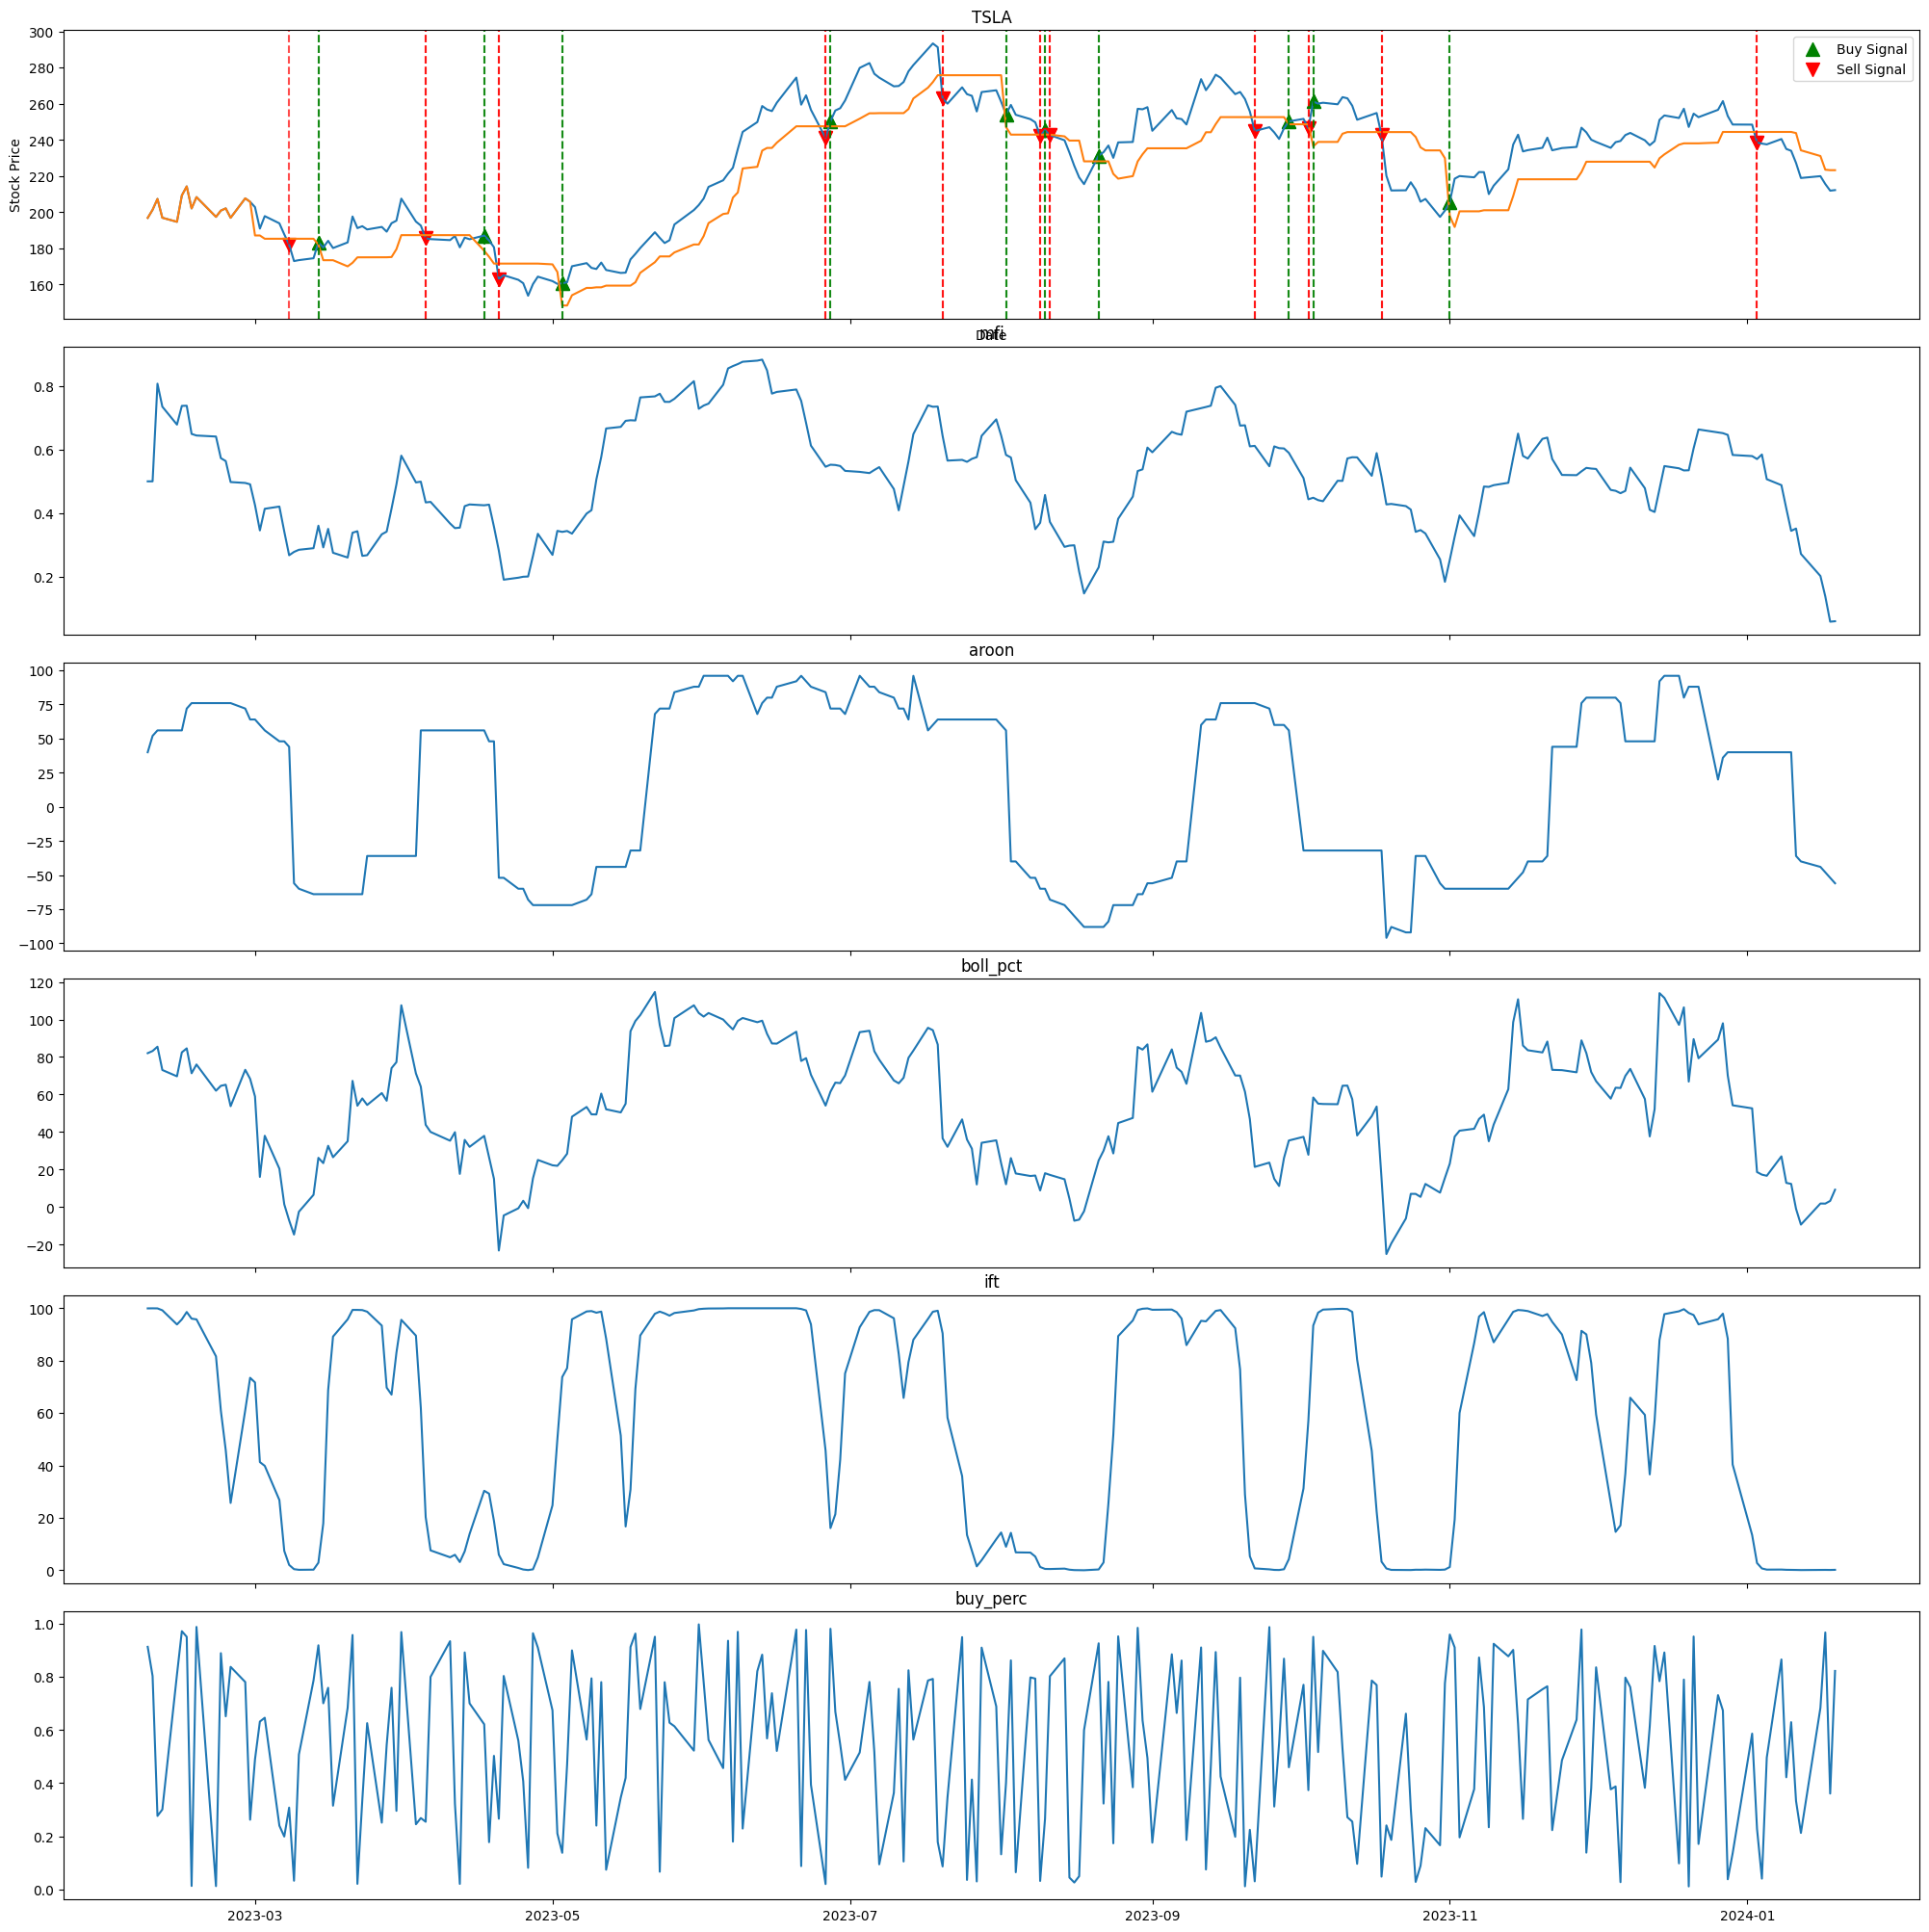

TSLA
            signal       close        p/l
2023-10-03    -1.0  246.529999  -3.690002
2023-10-03    -1.0  246.529999   0.000000
2023-10-04     1.0  261.160004 -14.630005
2023-10-04     1.0  261.160004   0.000000
2023-10-18    -1.0  242.679993 -18.480011
2023-10-18    -1.0  242.679993   0.000000
2023-11-01     1.0  205.660004  37.019989
2023-11-01     1.0  205.660004   0.000000
2024-01-03    -1.0  238.449997  32.789993
2024-01-03    -1.0  238.449997   0.000000

Total P/L: 105.45

Buy and hold: 15
Total Win Rate: 43.9 %

# trades: 41


In [ ]:
# ATR, HHV, and Mult inputs


def rma(df, length):
    alpha = 1 / length
    sum_val = None
    rma_values = []

    for i in range(len(df)):
        if pd.isna(sum_val):
            sum_val = df['true_range'].iloc[:i+1].mean()
        else:
            sum_val = alpha * df['true_range'].iloc[i] + (1 - alpha) * sum_val
        # print(df.index[i], df['true_range'].iloc[i], sum_val)
        rma_values.append(sum_val)

    df = df.assign(rma=rma_values)
    return df['rma']

# Function to calculate ATR
def calculate_atr(df, atr_period):
    df['true_range'] = df.apply(lambda row: max(row['high'] - row['low'], abs(row['high'] - row['close_shifted']), abs(row['low'] - row['close_shifted'])), axis=1)
    df['ATR'] = rma(df, atr_period)
    return df

# Function to calculate HHV
def calculate_hhv(df, hhv_period, mult):
    df['AdjustedHigh'] = df['high'] - mult * df['ATR']
    df['HHV'] = df['AdjustedHigh'].rolling(window=hhv_period).max()
    return df

# Function to determine the Trailing Stoploss
def calculate_trailing_stoploss(row):
    if row['cum_sum'] < 16:
        return row['close']
    else:
        return row['HHV']

def calculate_ift_stochastic(df, stochlength=5, wmalength=9):
    # Calculate Stochastic and Inverse Fisher Transform
    df['stoch'] = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=stochlength).stoch()
    df['v1'] = 0.1 * (df['stoch'] - 50)
    df['v2'] = ta.trend.WMAIndicator(df['v1'], window=wmalength).wma()
    df['ift'] = 50*((np.exp(2 * df['v2']) - 1) / (np.exp(2 * df['v2']) + 1)+1)
    # print(df)
    return df

def get_buy_sell_v(df):
  df['BuyingVolume'] = df['volume'] * (df['close'] - df['low']) / (df['high'] - df['low'])
  df['SellingVolume'] = df['volume'] * (df['high'] - df['close']) / (df['high'] - df['low'])
  df['buy_perc'] = df['BuyingVolume']/(df['SellingVolume']+df['BuyingVolume'])
  # print(df)
  return df

def generate_signals(data):
    data['Signal'] = 0  # 0 for no signal, 1 for buy, -1 for sell
    # when we close a position, we open a new position with same direction
    # Buy signal (crossover)
    buy_condition1 = (data['cum_sum']>16) & (data['close'] > data['TS']) & (data['close'].shift(1) <= data['TS'].shift(1))
    # buy_condition2 = (data['mfi']<0.28) & (data['aroon'] <-50) & (data['boll_pct'] < 10)
    # buy_condition = buy_condition1 & buy_condition2
    data.loc[buy_condition1, 'Signal'] = 1

    # Sell signal (crossunder)
    sell_condition1 = (data['cum_sum']>16) & (data['close'] < data['TS']) & (data['close'].shift(1) >= data['TS'].shift(1))
    # sell_condition2 = (data['mfi']>0.80) & (data['aroon'] >50) & (data['boll_pct'] >90)
    # sell_condition = sell_condition1 & sell_condition2
    data.loc[sell_condition1, 'Signal'] = -1
    return data

for i, ticker in enumerate(watching):
  if len(watching) == 1:
    _ticker = data.copy()
  else:
    _ticker = data[ticker].copy()
  # _ticker = _ticker.resample('4H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
  _ticker = sdf.retype(_ticker)
  # print(df)
  _ticker.index.drop_duplicates(keep='first')
  df = _ticker.copy()
  for indicator in INDICATORS:
    if indicator == 'boll_pct':
      df[indicator] = (_ticker['close'] - _ticker['boll_lb']) / (
        _ticker['boll_ub'] - _ticker['boll_lb']) * 100
    elif indicator == 'ift':
      df = calculate_ift_stochastic(df)
    elif indicator == 'buy_perc':
      df = get_buy_sell_v(df)
    else:
      df[indicator] = _ticker[indicator]

  # df = df[df.columns.tolist() + INDICATORS]
  # print(df)
  df.dropna(inplace=True)
  # Calculate Previous value
  df['close_shifted'] = df['close'].shift(1)
  # Calculate ATR
  df = calculate_atr(df, atr_period)
  # Calculate HHV
  df = calculate_hhv(df, hhv_period, mult)

  # Calculate cumulative sum
  df['cum_sum'] = np.cumsum(np.ones(len(df)))


  # Calculate Trailing Stoploss
  df['TS'] = df.apply(calculate_trailing_stoploss, axis=1)
  # print(df[['close', 'TS', 'true_range', 'atr']].to_string())

  # print(df)
  # Plotting
  # plt.plot(df['close'],color = 'black', linewidth=1)
  # plt.plot(df['TS'],color = 'red', linewidth=1)
  # plt.title(ticker)
  # plt.show()

  df = generate_signals(df)
  # print(df)
  # Filter rows with buy/sell signals
  trades = df[df['Signal'] != 0]
  # print(trades)
  col_names = trades.columns
  open_positions = []
  cleaned_rows = []
  # print(df)
  for index, row in trades.iterrows():
      if row['signal'] != 0:
          # open a new position
          if not open_positions:
              open_positions.append(row['signal'])
              cleaned_rows.append(row)
          # close a position then immediately open a position
          elif open_positions[-1] != row['signal']:
              open_positions.pop()
              cleaned_rows.append(row)
              cleaned_rows.append(row)
              open_positions.append(row['signal'])
  # print(cleaned_rows)
  trades = pd.DataFrame(cleaned_rows, columns=col_names)
  # print(trades)
  fig, ax = plt.subplots(len(INDICATORS)+1, 1, figsize=(20, 20), sharex = True)
  fig.tight_layout()

  ax[0].set_title(ticker, loc='center')
  ax[0].plot(df['close'])
  ax[0].plot(df['TS'])

  buy_signals = trades[trades['signal'] == 1]
  ax[0].scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal', s=100)
  for date in buy_signals.index:
      ax[0].axvline(x=date, color='g', linestyle='--', alpha=0.7)
  ax[0].set_xlabel('Date')
  ax[0].set_ylabel('Stock Price')

  sell_signals = trades[trades['signal'] == -1]
  ax[0].scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal', s=100)
  for date in sell_signals.index:
      ax[0].axvline(x=date, color='r', linestyle='--', alpha=0.7)

  ax[0].legend()

  for i, x in enumerate(INDICATORS):
    ax[i+1].set_title(x, loc='center')
    ax[i+1].plot(df[x])

  plt.show()
  # Calculate P/L for each transaction
  trades['p/l'] = trades['signal'].shift(1) * (trades['close'] - trades['close'].shift(1))
  trades['shifted_signal'] = trades['signal'].shift(1)
  trades['p/l'] = trades.apply(lambda row: 0 if row['signal'] == row['shifted_signal'] else row['p/l'], axis=1)
  # if trades.iloc[0]['signal'] == -1:
  #   trades['p/l'] = trades.apply(lambda row: 0 if row['signal'] == -1 else row['p/l'], axis=1)
  # else:
  #   trades['p/l'] = trades.apply(lambda row: 0 if row['signal'] == 1 else row['p/l'], axis=1)
  # print(trades)
  # Calculate total P/L and win rate
  total_pl = trades['p/l'].sum()
  win_trades = trades[trades['p/l'] > 0]
  total_win_rate = len(win_trades) / len(trades) *2 * 100 if len(trades) > 0 else 0

  # Display results
  bnh = round(df.iloc[-1]['close'] - df.iloc[0]['close'])
  # print("\nTotal P/L:", round(total_pl, 2))
  # print(trades[['signal', 'close', 'p/l']].to_string())
  if total_pl>0 and total_pl>bnh:
    print(ticker)
    # # print("\nTrades:")
    print(trades[['signal', 'close', 'p/l']][-10:].to_string())
    print("\nTotal P/L:", round(total_pl, 2))
    print('\nBuy and hold:', bnh)
    print("Total Win Rate:", round(total_win_rate, 2), "%")
    print('\n# trades:', len(trades))
    print('===================')



In [ ]:
# ATR, HHV, and Mult inputs
atr_period = 5
hhv_period = 10
mult = 2.5
watching=['GOOG']
interval = '1d'
period = '6mo'
data = yf.download(tickers=watching, period=period, interval=interval, group_by='ticker', auto_adjust=True)
# print(data)


# print(data.head())
data.index.drop_duplicates(keep='first')
data.dropna(inplace=True)
def rma(df, length):
    alpha = 1 / length
    sum_val = None
    rma_values = []

    for i in range(len(df)):
        if pd.isna(sum_val):
            sum_val = df['true_range'].iloc[:i+1].mean()
        else:
            sum_val = alpha * df['true_range'].iloc[i] + (1 - alpha) * sum_val
        rma_values.append(sum_val)

    df = df.assign(rma=rma_values)
    return df['rma']

# Function to calculate ATR
def calculate_atr(df, atr_period):
    df['true_range'] = df.apply(lambda row: max(row['high'] - row['low'], abs(row['high'] - row['close_shifted']), abs(row['low'] - row['close_shifted'])), axis=1)
    df['ATR'] = rma(df, atr_period)
    return df

# Function to calculate HHV
def calculate_hhv(df, hhv_period, mult):
    df['AdjustedHigh'] = df['high'] - mult * df['ATR']
    df['HHV'] = df['AdjustedHigh'].rolling(window=hhv_period).max()
    return df

# Function to determine the Trailing Stoploss
def calculate_trailing_stoploss(row):
    if row['cum_sum'] < 16:
        return row['close']
    else:
        return row['HHV']


def generate_signals(data):
    data['Signal'] = 0  # 0 for no signal, 1 for buy, -1 for sell
    # print(data)
    # Buy signal (crossover)
    buy_condition = (data['cum_sum']>16) & (data['close'] > data['TS']) & (data['close'].shift(1) <= data['TS'].shift(1))
    data.loc[buy_condition, 'Signal'] = 1

    # Sell signal (crossunder)
    sell_condition = (data['cum_sum']>16) & (data['close'] < data['TS']) & (data['close'].shift(1) >= data['TS'].shift(1))

    data.loc[sell_condition, 'Signal'] = -1
    return data

def run_atr():
  for i, ticker in enumerate(watching):
    if len(watching) == 1:
      _ticker = data
    else:
      _ticker = data[ticker]
      # _ticker = _ticker.resample('4H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

    df = sdf.retype(_ticker)
    df.index.drop_duplicates(keep='first')
    df.dropna(inplace=True)

    # Calculate Previous value
    df['close_shifted'] = df['close'].shift(1)
    # Calculate ATR
    df = calculate_atr(df, atr_period)
    # print(df)
    # Calculate HHV
    df = calculate_hhv(df, hhv_period, mult)

    # Calculate cumulative sum
    df['cum_sum'] = np.cumsum(np.ones(len(df)))


    # Calculate Trailing Stoploss
    df['TS'] = df.apply(calculate_trailing_stoploss, axis=1)
    # print(df[['TS', 'true_range', 'atr']])

    # print(df)
    # Plotting
    # plt.plot(df['close'],color = 'black', linewidth=1)
    # plt.plot(df['TS'],color = 'red', linewidth=1)
    # plt.title('ATR Trailing Stoploss')
    # plt.show()

    df = generate_signals(df)
    # print(df)
    # Filter rows with buy/sell signals
    trades = df[df['Signal'] != 0][['close', 'signal']]
    # if trades.iloc[0]['signal'] == -1:
    #   trades = trades.drop(trades.index[0])
    # if trades.iloc[-1]['signal'] == 1:
    #   trades = trades.drop(trades.index[-1])
    # Calculate P/L for each transaction
    trades['p/l'] = trades['signal'].shift(1) * (trades['close'] - trades['close'].shift(1))
    trades['p/l'] = trades.apply(lambda row: 0 if row['signal'] == 1 else row['p/l'], axis=1)
    # print(trades)
    # Calculate total P/L and win rate
    total_pl = trades['p/l'].sum()
    win_trades = trades[trades['p/l'] > 0]
    total_win_rate = len(win_trades) / len(trades) * 100 if len(trades) > 0 else 0

    # Display results
    bnh = round(df.iloc[-1]['close'] - df.iloc[0]['close'])
    print(ticker)
    print("\nTrades:")
    print(trades.to_string())

    print("\nTotal P/L:", round(total_pl, 2))
    print('\nBuy and hold:', bnh)
    print("Total Win Rate:", round(total_win_rate, 2), "%")
    print('\n# trades:', len(trades))
    print('===================')

run_atr()

[*********************100%%**********************]  1 of 1 completed
GOOG

Trades:
                 close  signal        p/l
Date                                     
2023-07-20  119.529999      -1        NaN
2023-07-21  120.309998       1   0.000000
2023-09-21  131.360001      -1  11.050003
2023-10-02  135.169998       1   0.000000
2023-10-25  126.669998      -1  -8.500000
2023-11-07  132.399994       1   0.000000
2023-11-30  133.919998      -1   1.520004
2023-12-07  138.449997       1   0.000000

Total P/L: 4.07

Buy and hold: 10
Total Win Rate: 25.0 %

# trades: 8
